In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import enum
import itertools
import operator
import collections
import math
import codecs
from scipy import stats

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use('ggplot')

# Theoretical Part

## 1.a

Type I error occurs when a hypothesis test rejects $H_0$ indicating significance, where in reality this should not be the case. The probability of Type I error is as follows:
P($H_0$ is rejected | $H_0$ is true) = $\alpha$

Hence, in order to obtain the probability asked in this question, we multiply the probability of not making a Type I error in the first m-1 cases and making this error at the $m^{th}$ case.

P($m^{th}$ experiment gives significant result | m experiments lacking power to reject $H_0$) = $(1-\alpha)^{m-1}\alpha$

## 1.b
We calculate the probability of at least one significant result in the presence of experiments that cannot reject the null hypothesis as indicated below, subtracting the probability of not making a Type I error at all from 1.

P(at least one significant result | m experiments lacking power to reject $H_0$) = 1 - $(1-\alpha)^m$



## 2
Both balanced interleaving and team-draft interleaving do not take the similarity of the lists into consideration. In cases where the ranks of the documents retrieved by two different search algorithms are similar, the comparison based on clicks given interleaved lists might be biased [Hofmann et al. 2011, 2013]. If the documents are swapped or their ranks are shifted by one level, team-draft interleaving might fail to capture the difference between the two algorithms. 

Similar to the examples given in Hofmann et al. [2011, 2013], we can consider 2 lists $l_1$ and $l_2$, both retrieving $d_1$, $d_2$ and $d_3$ in similar rankings such as: $l_1 = [d_1,d_2,d_3]$ and $l_2 = [d_2,d_3,d_1]$. If we take $d_3$ as the relevant document and assume that the one and only click occur on $d_3$, we expect that the score of $l_2$ output by the interleaving function should be higher than $l_1$'s score. The reason for this is that $l_2$ places the relevant document in the higher levels. 

When we construct possible interleaved lists, we observe that $d_3$ is placed at the 3rd rank in all of these lists as in the figure below:

<img src="interleaving.png">

When the clicks are on $d_3$, both lists will acquire the same score of 2. This will result in a tie and the actual difference between the qualities of the algorithms will be overlooked ($l_2$ being better than $l_1$). They both get 50%, whereas the second list should have received a better score. As a result, this team-draft interleaving can be biased and be unfair to the better algorithm.

In addition, ambiguous queries can lead to biased outcomes in team-draft interleaving where the rankings are shifted by one as indicated in [Chapelle et al. 2012].

Chapelle, O., Joachims, T., Radlinski, F., and Yue,Y. Large scale validation and analysis of interleaved search evaluation. ACM Transactions on Information Science, 30(1), 2012.

Hofmann, K., Whiteson, S., and de Rijke, M. A probabilistic method for inferring preferences from clicks. In
CIKM ’11, pp. 249–258, USA, 2011. ACM.

Hofmann, Katja, Whiteson, Shimon, and de Rijke, Maarten. Fidelity, soundness, and efficiency of interleaved
comparison methods. ACM Transactions on Information Systems, 31(4), 2013.



# Experimental Part

### Assumptions:
- Grades:
    - Grade for Highly Relevant (HR) = 2
    - Grade for Relevant (R) = 1
    - Grade for Not relevant (N) = 0
- Number of documents
    - Total number of documents is 30. The number of unique documents that are:
        - HR: 10
        - R: 10
        - N: 10
- For the Alpha, we decided to set them according to relevance as below:
    - HR: 0.9
    - R: 0.5
    - N: 0.1
- For the Sigma we decided to take a global sigma, which was calculated by dividing (satisfying_clicks)/(total_clicks) = 0.5121189928157913
- Documents returned by 2 algorithms are all assumed to be unique.
- One of the central assumptions is the Single Query Assumption. We can assume that the entire experiment is for a single query; hence, as a result there are only 10 R + 10 HR documents i.e a total of 20 relevant documents.


As evaluation measures, we have implemented Average Precision, Normalized Discounted Cumulative Gain (also Discounted Cumulative Gain) and Expected Reciprocal Rank. We also implemented Recall, Precision; however, they were not utilized during simulation. Click models we implemented were the Random Click Model and the Simple Dynamic Bayesian Network. 

In [2]:
@enum.unique
class Grade(enum.IntEnum):
    """
    Represents relevance on a graded scale. 
    Any positive number represents relevance, with higher numbers representing higher relevance (total ordering)
    Zero represents irrelevant
    """
    N = (0)   # Not relevant
    R = (1)   # Relevant
    HR = (2)  # Highly relevant

    
    @property
    def is_relevant(self):
        """
        'Binarizes' the relevance. Useful for computing binary metrics like precision / recall
        """
        return False if self.value == 0 else True
    
    @classmethod
    def from_int_list(cls, int_list):
        """
        Converts a list of integers to a list of Grade
        """
        members = dict((member.value, member) for member in cls.__members__.values())
        return [members[value] for value in int_list]

    @classmethod
    def max_grade(cls):
        return max(member.value for member in cls.__members__.values())

    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name

## Step 1: Simulate Rankings of Relevance for E and P (5 points)

In this step we generated pairs of rankings of relevance given P and E, respectively production and experimental. The relevance labels were N, R and HR. Each item consists of 5 rankings.

Example:

P: {N N N N N}
E: {N N N N R}

…
P: {HR HR HR HR R}
E: {HR HR HR HR HR}

In [3]:
def get_all_permutations(grade, sequence_length):
    """
    For a given grade and a sequence length n, returns all possible permutations of length n that can be formed. 
    Note that a generator is returned and not a list
    """
    for i, perm in enumerate(itertools.product(range(len(grade.__members__)), repeat=sequence_length)):
        yield grade.from_int_list(perm)

def get_all_permutation_pairs(grade, sequence_length):
    """
    Generates all possible pairs of permutations given a grade and a sequence length.
    Note that a generator is returned and not a list
    """
    sequence_1 = get_all_permutations(grade, sequence_length)
    sequence_2 = get_all_permutations(grade, sequence_length)    
    for pair in itertools.product(sequence_1, sequence_2):
        yield pair
        
def count_sequence(seq):
    """
    `len` for generators
    """
    count = 0
    for _ in seq:
        count += 1
    return count

# A sanity check to ensure the correct number of sequences are being generated
assert count_sequence(get_all_permutation_pairs(Grade, 5)) == (3**5) * (3**5)

In [4]:
permutations = np.array(list(get_all_permutation_pairs(Grade, 5)), dtype=np.object)

In [5]:
permutations

array([[[N, N, N, N, N],
        [N, N, N, N, N]],

       [[N, N, N, N, N],
        [N, N, N, N, R]],

       [[N, N, N, N, N],
        [N, N, N, N, HR]],

       ..., 
       [[HR, HR, HR, HR, HR],
        [HR, HR, HR, HR, N]],

       [[HR, HR, HR, HR, HR],
        [HR, HR, HR, HR, R]],

       [[HR, HR, HR, HR, HR],
        [HR, HR, HR, HR, HR]]], dtype=object)

In [6]:
permutations[0]

array([[N, N, N, N, N],
       [N, N, N, N, N]], dtype=object)

In [7]:
permutations[-1]

array([[HR, HR, HR, HR, HR],
       [HR, HR, HR, HR, HR]], dtype=object)

In [8]:
production = np.array(list(map(operator.itemgetter(0), permutations)))
experiment = np.array(list(map(operator.itemgetter(1), permutations)))

In [9]:
# TODO double check this
relevant_count_production = 20
relevant_count_experiment = 20
(relevant_count_experiment, relevant_count_production)

(20, 20)

## Step 2: Implement Evaluation Measures (10 points)
Implement 1 binary and 2 multi-graded evaluation measures out of the 7 measures mentioned above. 

Note:
We've implemented all metrics. For grading, please consider AveragePrecision (1 binary), NDCG@k and ERR (2 multi-graded)

In [10]:
class Metric:
    """
        Common parent for all metrics
    """
    
    def name(self):
        raise NotImplementedError()
    
    def compute(self, results, **kwargs):
        """ Template for a computation """
        raise NotImplementedError()

class Precision(Metric):
    """
        Computes precision at rank-k, or if rank is not specified, it is computed for the entire list
    """
    
    @property
    def name(self):
        return "precision"
    
    def compute(self, results, **kwargs):
        # if k is not specified, the entire list is used
        k = kwargs.get("k", len(results))
        
        # only up to k
        results = results[:k]
        # binarize, compute how many are relevant and divide by k
        return sum(r.is_relevant for r in results) / k
    
class Recall(Metric):
    """
        Computes recall at rank-k, or if rank is not specified, it is computed for the entire list
        Note: Requires total number of relevant documents
    """
    
    @property
    def name(self):
        return "recall"
    
    def compute(self, results, **kwargs):
        assert "relevant_count" in kwargs
        # if k is not specified, the entire list is used
        k = kwargs.get("k", len(production))
        
        # only up to k
        results = results[:k]
        
        return sum(r.is_relevant for r in results) / kwargs["relevant_count"] 
        
    
class AveragePrecision(Metric):
    """
        Compute average precision at rank-k. 
        Note: Requires total number of relevant documents
    """
    
    @property
    def name(self):
        return "average-precision"
    
    def compute(self, results, **kwargs):
        assert "relevant_count" in kwargs
        P = Precision()
        precisions = np.zeros(len(results))
        for k in range(1, len(results) + 1):
            if(str(results[k-1]) != 'N'):
                precisions[k - 1] = P.compute(results, k = k)
        # TODO verify
        return precisions.sum() / kwargs["relevant_count"] 

AP = AveragePrecision()
ap = np.array([AP.compute(r, relevant_count = relevant_count_production) for r in production])
print(ap)

[ 0.    0.    0.   ...,  0.25  0.25  0.25]


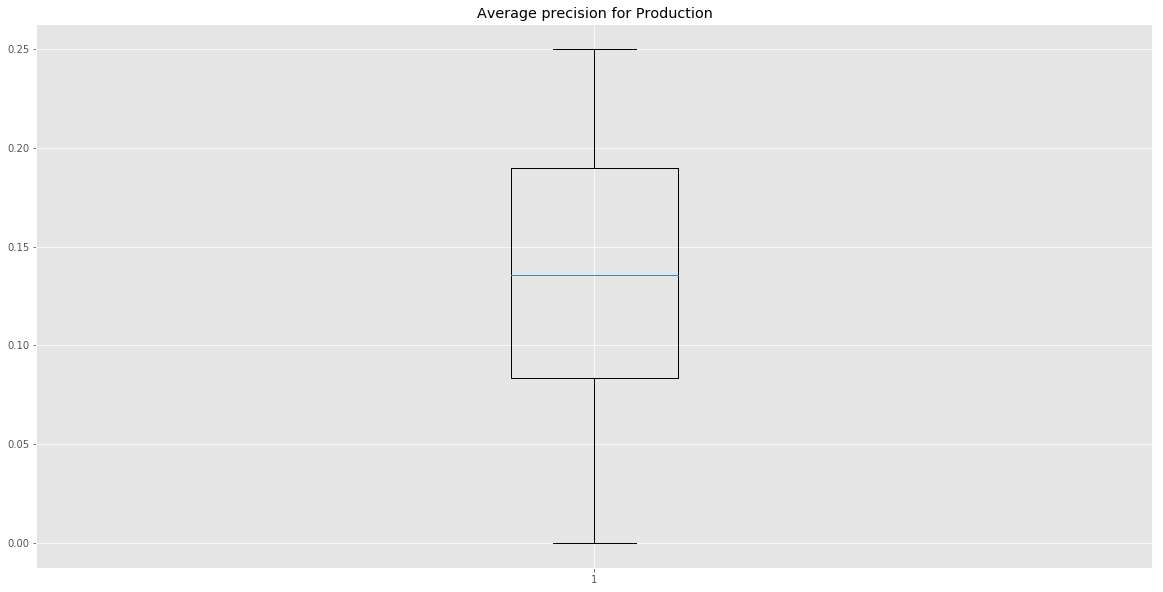

In [11]:
plt.boxplot(ap)
plt.title("Average precision for Production")
plt.show()

In [12]:
ap.mean()

0.13648148148148148

In [13]:
ap.max(), production[ap.argmax()]

(0.25, array([R, R, R, R, R], dtype=object))

In [14]:
ap.min(), production[ap.argmin()]

(0.0, array([N, N, N, N, N], dtype=object))

If we assume the retrieved documents are all relevant, that is all 5 documents retrieved by the algorithm are labeled either highly relevant or relevant, we get 100% precision at each rank. Since the total number of relevant documents in the collection is 20, the maximum Average Precision we get is (1+1+1+1+1)/20 = 25%

In [15]:
class DCG(Metric):
    
    """ 
        Compute the discounted cumulative gain at rank-k
    """
    
    @property
    def name(self):
        return "DCG@k"
    
    def compute(self, results, **kwargs):
        
        # if k is not specified, the entire list is used
        k = kwargs.get("k", len(production))
        
        # only up to k
        results = results[:k]
        
        dcg = 0.0 
        for rank, result in enumerate(results):
            rank += 1 # TODO verify
            gain = 2**result.value - 1
            discount = math.log2(1 + rank)
            dcg += gain / discount
        return dcg


class NDCG(Metric):
    """ 
        Compute the Normalized-DCG at rank-k.
        Note: This requires the ideal-ranking for all the documents in the collection (or upto rank-k)
    """

    @property
    def name(self):
        return "NCDG@k"
    
    
    def compute(self, results, **kwargs):
        assert "ideal_ranking" in kwargs
        
        # Normalization is done according to the slides mentioned here 
        # https://web.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
        
        dcg = DCG()
        
        ideal_ranking = kwargs["ideal_ranking"]
        
        # if k is not specified, the entire list is used
        k = kwargs.get("k", len(results))
        
        # only up to k
        results = results[:k]
        ideal_ranking = ideal_ranking[:k]
        
        max_dcg = dcg.compute(ideal_ranking)
        
        return dcg.compute(results) / max_dcg

ideal_ranking = [Grade.HR] * 10 + [Grade.R] * 10 + [Grade.N] * 10
print(ideal_ranking)

[HR, HR, HR, HR, HR, HR, HR, HR, HR, HR, R, R, R, R, R, R, R, R, R, R, N, N, N, N, N, N, N, N, N, N]


In [16]:
class ERR(Metric):
    @property
    def name(self):
        return "ERR"
    def compute(self, results, **kwargs):
        # Implementation follows this paper:
        # http://delivery.acm.org/10.1145/1650000/1646033/p621-chapelle.pdf?ip=145.109.35.88&id=1646033&acc=ACTIVE%20SERVICE&key=0C390721DC3021FF%2E86041C471C98F6DA%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&CFID=1026312371&CFTOKEN=18042814&__acm__=1515748872_543fbe0fe6a5c9d1fadb8f8341c9da3c
        assert "grade" in kwargs
        grade = kwargs["grade"]
        
        def r_func(result):
            return ((2 ** result.value) - 1) / (2 ** grade.max_grade())  
        
        err = 0.0
        for rank, result in enumerate(results):
            previous_results = results[:rank]
            satisfaction = 1
            for previous_result in previous_results:
                satisfaction = satisfaction * ((1 - r_func(previous_result)))
            # rank is 0-indexed here, so add 1
            err += (1/(rank + 1)) * satisfaction * r_func(result)
        
        return err

err = ERR()
print(err.compute([Grade.HR, Grade.HR, Grade.HR, Grade.HR], grade=Grade))
print(err.compute([Grade.N, Grade.N, Grade.N, Grade.HR], grade=Grade))

0.8623046875
0.1875


## Step 3: Calculate the 𝛥measure (0 points)

For the three measures and all P and E ranking pairs constructed above calculate the difference: 𝛥measure = measureE-measureP. Consider only those pairs for which E outperforms P.

In [17]:
# make a class that holds all the data for further experiments
ExperimentData = collections.namedtuple("ExperimentData", ["metric", "mask", "delta_measure", "permutations"])

Here we filter out all values where the delta measure is < 0. We do this for every evaluation metric
(AP, NCDG, ERR). We create masking arrays which return true if larger than 0 and false if smaller than zero.

These arrays are used for consequent analyses. The class which holds all the data is called ExperimentData

In [18]:
experiment_data = []

# data using Average Precision
average_precision = AveragePrecision()
ap_P = np.array([average_precision.compute(results, relevant_count = relevant_count_production) \
                                for results in production])
ap_E = np.array([average_precision.compute(results, relevant_count = relevant_count_experiment) \
                                for results in experiment])
ap_delta_measure = ap_E - ap_P
ap_mask = ap_delta_measure > 0
average_precision_data = ExperimentData(average_precision.name, ap_mask, ap_delta_measure, permutations[ap_mask])

experiment_data.append(average_precision_data)
##############################

# data using NCDG@k
ndcg = NDCG()
ncdg_P = np.array([ndcg.compute(results, ideal_ranking=ideal_ranking) for results in production])
ncdg_E = np.array([ndcg.compute(results, ideal_ranking=ideal_ranking) for results in experiment])
ndcg_delta_measure = ncdg_E - ncdg_P
ndcg_mask = ndcg_delta_measure > 0
ndcg_data = ExperimentData(ndcg.name, ndcg_mask, ndcg_delta_measure, permutations[ndcg_mask])
experiment_data.append(ndcg_data)
###################


# data using ERR
err = ERR()
err_P = np.array([err.compute(results, grade=Grade) for results in production])
err_E = np.array([err.compute(results, grade=Grade) for results in experiment])
err_delta_measure = err_E - err_P
err_mask = err_delta_measure > 0
err_data = ExperimentData(err.name, err_mask, err_delta_measure, permutations[err_mask])
experiment_data.append(err_data)
################

# include all the data
#experiment_data.append(ExperimentData("No metric", np.array([True] * len(permutations)), 
#                                      np.zeros(len(permutations)), permutations))

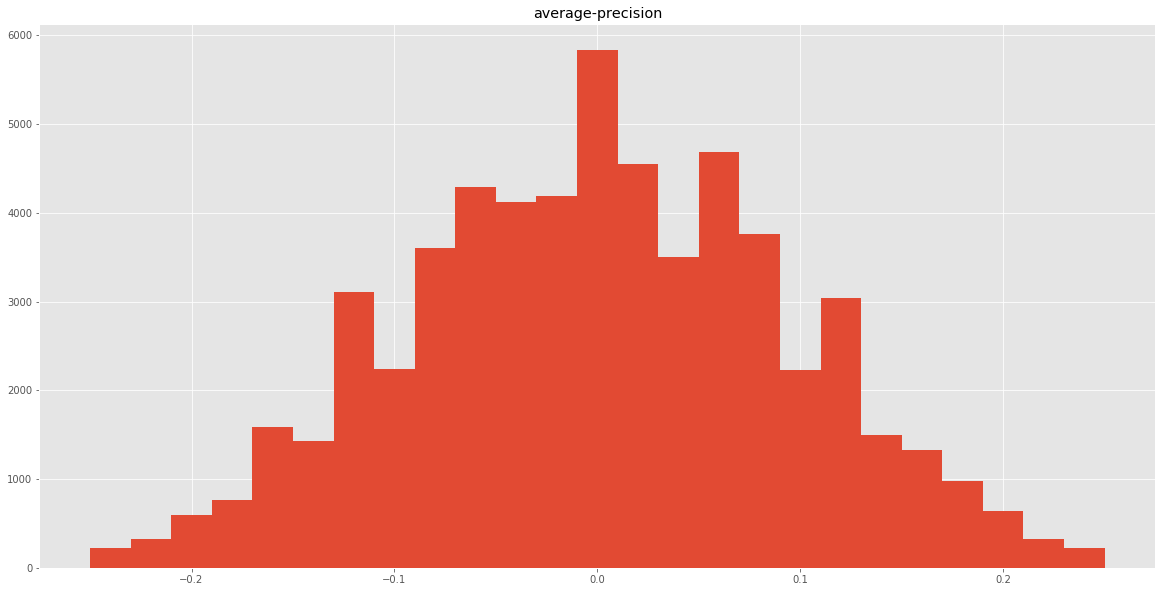

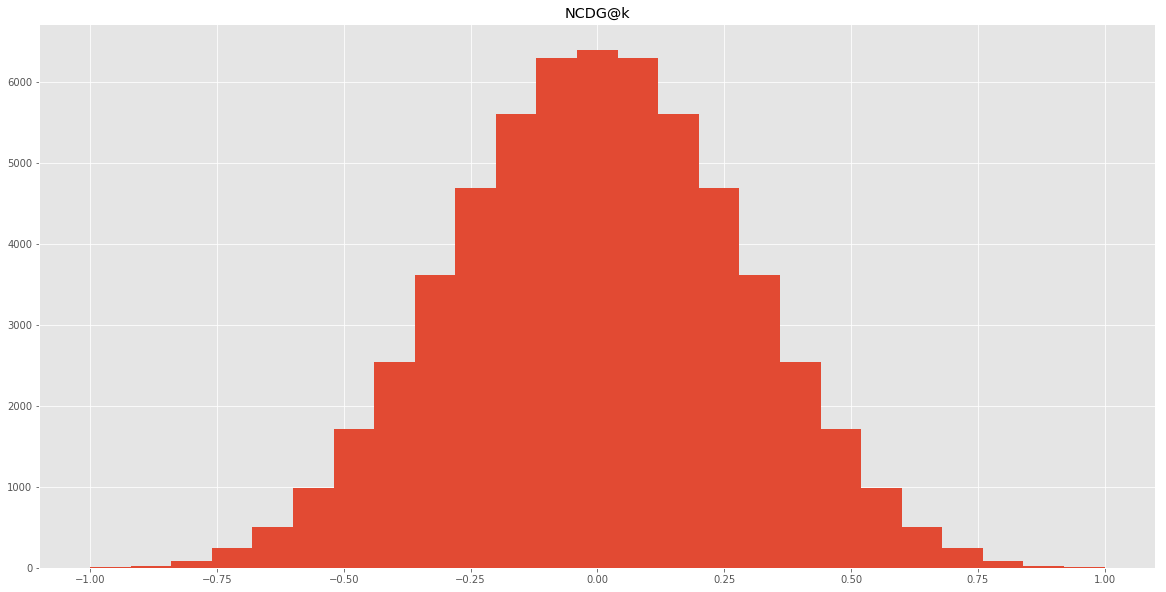

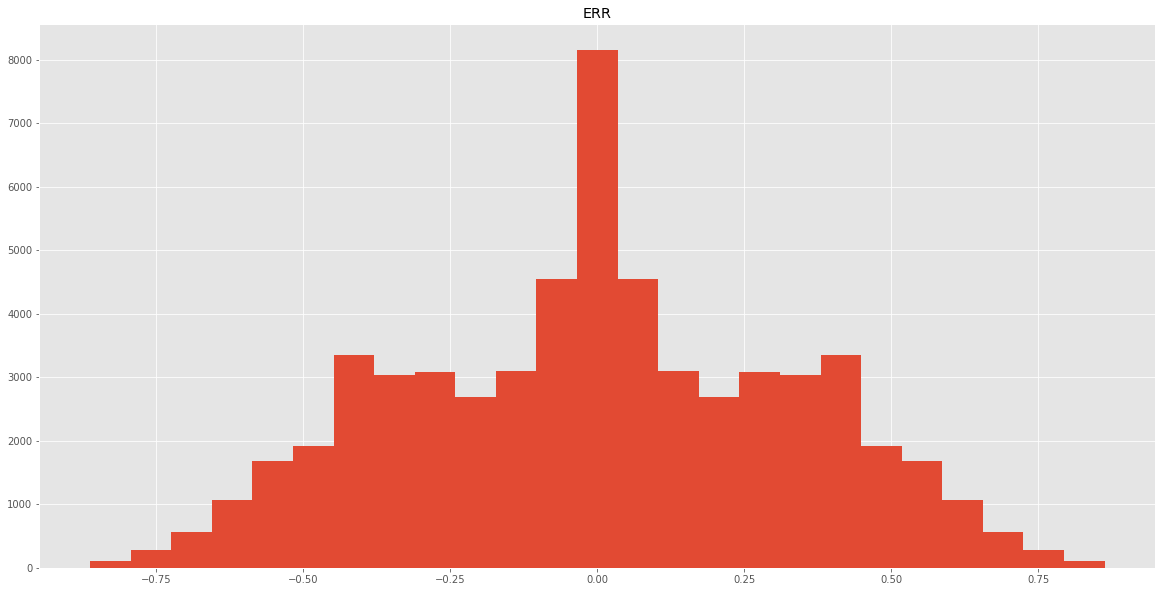

In [19]:
for data in experiment_data:
    plt.hist(data.delta_measure, bins=25)
    plt.title(data.metric)
    plt.show()

## Step 4: Implement Interleaving (15 points)
Implement 2 interleaving algorithms: 
(1) Team-Draft Interleaving OR Balanced Interleaving, ~~AND (2), Probabilistic Interleaving.~~ 

The interleaving algorithms should (a) given two rankings of relevance interleave them into a single ranking, and (b) given the users clicks on the interleaved ranking assign credit to the algorithms that produced the rankings.

In [20]:
def toss_coin(heads = 0.5):
    # head = True, Tails is False
    return True if random.random() < heads else False

Reference materials for interleaving algorithms: 
- https://www.cs.cornell.edu/people/tj/publications/radlinski_etal_08b.pdf
- https://www.cs.cornell.edu/people/tj/publications/chapelle_etal_12a.pdf

We followed the algorithms given in these papers as well as the lecture slides. 

Team-draft and balanced interleaving methods we implemented were employed during simulation. These methods receive 2 lists and output a combination, which was constructed through coin tosses and giving one algorithm preference to add a document from its list. (Either once at the beginning of interleaving or during each selection). Scores were calculated per algorithm via counting the clicks that correspond to a certain algorithm.

In [21]:
Interleaved = collections.namedtuple("Interleaved", ["source", "source_index", "result"])
        
class BalancedInterleaving:
    
    @staticmethod
    def interleave(A, B, A_name, B_name):

        selected = toss_coin()
        interleaved = []
        
        ka = 0
        kb = 0
        
        while(ka <= len(A) and kb <= len(B) and (ka < len(A) or kb < len(B))):

            if (ka < kb) or (ka==kb and selected):
                    tup = Interleaved(A_name, ka, A[ka])
                    # assumption: all docs are unique, most recently picked document is not in the interleaved list
                    # get next document from A
                    interleaved.append(tup)
                    ka += 1

            else:  
                    tup = Interleaved(B_name, kb, B[kb])
                    # assumption: all docs are unique, most recently picked document is not in the interleaved list
                     # get next document from B
                    interleaved.append(tup)
                    kb += 1
        
        return interleaved
    
    @staticmethod
    def score_clicks(interleaved, clicks):
        scores = collections.defaultdict(int)
        
        #assumption: all docs are unique, just count the clicks belonging to each algorithm
        
        #counts the number of clicks per source algorithm 
        for c in clicks:
            il = interleaved[c]
            scores[il.source] += 1
            
        return scores
    
A = [Grade.R, Grade.HR, Grade.N]
B = [Grade.R, Grade.N, Grade.HR]

interleaved = BalancedInterleaving.interleave(A, B, "A", "B")
interleaved

[Interleaved(source='A', source_index=0, result=R),
 Interleaved(source='B', source_index=0, result=R),
 Interleaved(source='A', source_index=1, result=HR),
 Interleaved(source='B', source_index=1, result=N),
 Interleaved(source='A', source_index=2, result=N),
 Interleaved(source='B', source_index=2, result=HR)]

In [22]:
clicks = [0, 2, 4]
BalancedInterleaving.score_clicks(interleaved, clicks)

defaultdict(int, {'A': 3})

In [23]:
class TeamDraftInterleaving:
    
    @staticmethod
    def interleave(A, B, A_name, B_name):

        interleaved = []
        TeamA = set()
        TeamB = set()

        ka = 0
        kb = 0

        while(ka <= len(A) and kb <= len(B)):
            selected = toss_coin()
            if ka == len(A) and kb == len(B):
                break #to include the last document
            elif(len(TeamA) < len(TeamB)) or (len(TeamA) == len(TeamB) and selected == 0):
                #get next document from A
                tup = Interleaved(A_name, ka, A[ka])
                interleaved.append(tup)
                TeamA.add(tup)
                ka += 1
            else:
                #get next document from B
                tup = Interleaved(B_name, kb, B[kb])
                interleaved.append(tup)
                TeamB.add(tup)
                kb +=1
               
        return interleaved

    @staticmethod
    def score_clicks(interleaved, clicks):
        scores = collections.defaultdict(int)
        
        #counts the number of clicks per source algorithm 
        for c in clicks:
            il = interleaved[c]
            scores[il.source] += 1
            
        return scores
                
A = [Grade.R, Grade.HR, Grade.N]
B = [Grade.R, Grade.N, Grade.HR]

interleaved = TeamDraftInterleaving.interleave(A, B, "A", "B")
interleaved

[Interleaved(source='A', source_index=0, result=R),
 Interleaved(source='B', source_index=0, result=R),
 Interleaved(source='B', source_index=1, result=N),
 Interleaved(source='A', source_index=1, result=HR),
 Interleaved(source='B', source_index=2, result=HR),
 Interleaved(source='A', source_index=2, result=N)]

## Yandex log
Here we "read" the raw Yandex data and read the array of Sessions (S)

We determine click actions (C) and query actions (Q)
We find the respective document lists and clicks

We assumed that every user session (s) has one or more queries which each produce 10 documents
Every single qeury can have clicks, where if there are clicks the last click is considered satisfactory.
Therefore, every user session can have multiple satisfactory clicks.

In [24]:
ClickAction = collections.namedtuple("ClickAction", ["clicked_id"])
QueryAction = collections.namedtuple("QueryAction", ["query_id", "results"])

class Session:
    def __init__(self, session_id):
        self.session_id = session_id
        self.data = []
    
    @property
    def clicks(self):
        return list(filter(lambda _: isinstance(_, ClickAction), self.data))
    
    @property
    def queries(self):
        return list(filter(lambda _: isinstance(_, QueryAction), self.data))
    
    def get_complete_interactions(self):
        # return complete interactions
        last_query = 0
        for index, action in enumerate(self.data):
            if index != 0 and isinstance(action, QueryAction):
                yield self.data[last_query: index]
                last_query = index
        if isinstance(self.data[-1], ClickAction):
            yield self.data[last_query:]
        
class YandexData:
    def __init__(self, file_path):
        self.file_path = file_path
        self.sessions = []
        self.u = 0
        self.q = 0
        self._read()
        
    def _read(self):
        with codecs.open(self.file_path, "r", "utf-8") as reader:
            current_session = Session(0)
            for line in reader:
                line = line.split("\t")
                session_id = int(line[0])
                interaction_type = line[2]
                if current_session.session_id != session_id:
                    self.sessions.append(current_session)
                    current_session = Session(session_id)
                
                if interaction_type == "C":
                    current_session.data.append(ClickAction(int(line[3])))
                else:
                    results = [int(q_id) for q_id in line[5:]]
                    self.u = max(self.u, max(results))
                    query_id = int(line[3])
                    self.q = max(self.q, query_id)
                    current_session.data.append(QueryAction(query_id, results))
        
        self.sessions.append(current_session)


yandex_data = YandexData("./YandexRelPredChallenge.txt")
print("Total number of sessions: ", len(yandex_data.sessions))
print("Total number of interactions: ", sum(len(session.data) for session in yandex_data.sessions))

Total number of sessions:  11717
Total number of interactions:  100000


## Step 5: Implement User Clicks Simulation (15 points)

Random Click Model (RCM)

Simple Dynamic Bayesian Network (SDBN)

For RCM we use "rho" which is calculated as the (total number of clicks)/(number of documents) = 0.13

We then flip a biased coin (rho) for every document in a list to simulate clicks.
The clicks are independent of rank. We return a list of indices which have been clicked (e.g. [2,5,7])


In [25]:
class RandomClickModel:
    def __init__(self):
        self.rho = 0
    
    def estimate(self, yandex_data):
        clicks = 0
        results = 0
        for session in yandex_data.sessions:
            clicks += len(session.clicks)
            results += sum(len(query.results) for query in session.queries)
        self.rho = clicks / results
    
    def predict(self, clicks):
        #(b) there is a method that predicts the click probability given a ranked list of relevance labels,
        pass
    
    @staticmethod
    def simulate(results, grade_to_probability, params):
        rho = params.get("rho")
        assert 0 <= rho <= 1.0
        
        # TODO something is wrong with this and I can't figure it out. pls fix 
        clicks = []
        for rank, result in enumerate(results):
            click = toss_coin(rho)
            if click:
                clicks.append(rank)
        return clicks

rcm = RandomClickModel()
rcm.estimate(yandex_data)
rcm.rho

0.13445559411047547

In [26]:
yandex_data.u, yandex_data.q

(527494, 66579)

For the SDBN we calculate the alpha and sigma for every single query-document pair. 
However in the end we use alpha based off of HR, R, N. (which we value as 0.9, 0.5, 0.1 respectively)
and we use a global sigma which is (satisfied clicks)/(all clicks)

To simulate clicks we start at document 1 and flip a biased coin (alpha) according to the document's relevance. 
If it is clicked we then flip another biased coin according to the global sigma to check satisfaction.

This is continued until satisfaction occurs or when we get to the end of the list.

We return a list of indices which have been clicked (e.g. [2,5,7])

In [27]:
class SimpleDynamicBayesianNetwork:
        
    def _estimate_sigma(self, yandex_data):
        satisfied_clicks = collections.defaultdict(lambda : collections.defaultdict(float))
        total_clicks = collections.defaultdict(lambda : collections.defaultdict(float))
        
        
        for session in yandex_data.sessions:
            for interaction in session.get_complete_interactions():
                #print(interaction) TODO explain why we continue
                if not isinstance(interaction[-1], ClickAction):
                    continue
                query_action = interaction[0]
                # sanity check TODO remove
                assert isinstance(query_action, QueryAction)
                for click in interaction[1:]:
                    # sanity check TODO remove
                    assert isinstance(click, ClickAction)
                    total_clicks[click.clicked_id][query_action.query_id] += 1
                
                last_click = interaction[-1]
                #print(last_click)
                satisfied_clicks[last_click.clicked_id][query_action.query_id] += 1
        
        self.sigma = collections.defaultdict(lambda : collections.defaultdict(float))
        
        all_clicks = 0
        all_satisfied = 0
        for click_id, queries in total_clicks.items():
            for query_id, count in queries.items():
                self.sigma[click_id][query_id] = satisfied_clicks[click_id][query_id] / count
                all_clicks += count
                all_satisfied += satisfied_clicks[click_id][query_id]
        
        self.sigma_global = all_satisfied / all_clicks
                
    def _estimate_alpha(self, yandex_data):
        seen = collections.defaultdict(lambda : collections.defaultdict(float))
        clicks = collections.defaultdict(lambda : collections.defaultdict(float))
        
        for session in yandex_data.sessions:
            for interaction in session.get_complete_interactions():
                query_action = interaction[0]
                assert isinstance(query_action, QueryAction)
                
                for result in query_action.results:
                    seen[result][query_action.query_id] += 1
                
                for click in interaction[1:]:
                    # sanity check TODO remove
                    assert isinstance(click, ClickAction)
                    clicks[click.clicked_id][query_action.query_id] += 1
                

        
        self.alpha = collections.defaultdict(lambda : collections.defaultdict(float))
        for click_id, queries in seen.items():
            for query_id, count in queries.items():
                self.alpha[click_id][query_id] = clicks[click_id][query_id] / count
    
    
    def estimate(self, yandex_data):
        self._estimate_sigma(yandex_data)
        self._estimate_alpha(yandex_data)
        
    @staticmethod
    def simulate(results, grade_to_probability, params):
        clicks = []
        sigma = params["sigma"]
        for index, result in enumerate(results):
            examine = toss_coin(grade_to_probability[result])
            if not examine:
                continue
            clicks.append(index)
            
            satisfied = toss_coin(sigma)
            if satisfied:
                break
                
        return clicks


In [28]:
"""
For the alpha we decided to set it according to relevance, see below.

For the Sigma we decided to take a global sigma, which was calculated by dividing
(satisfying_clicks)/(total_clicks) = 0.5121189928157913

"""


grade_to_probability = {
    Grade.N: 0.1,
    Grade.R: 0.5,
    Grade.HR: 0.9
}
    
sdbn = SimpleDynamicBayesianNetwork()
sdbn.estimate(yandex_data)
sdbn.sigma_global

0.5121189928157913

## Step 6 Simulate Interleaving Experiment (10 points)


Having implemented the click models, it is time to run the simulated experiment.
For each of interleaved ranking run N (30) simulations for each one of the click models implemented and measure the proportion p of wins for E.


In [29]:
def calculate_deltas(data):
    
    #calculates delta measures for each pair in the simulation
    ap_deltas = []
    ndcg_deltas = []
    err_deltas = []
    
    #uses masked data set
    for production, experimental in permutations[data.mask]:

        # data using Average Precision
        average_precision = AveragePrecision()
        ap_P = average_precision.compute(production, relevant_count = relevant_count_production)
        ap_E = average_precision.compute(experimental, relevant_count = relevant_count_production)
        ap_delta_measure = ap_E - ap_P
        ap_deltas.append(ap_delta_measure)
        ##############################
        
         # data using NCDG@k
        ndcg = NDCG()
        ncdg_P = ndcg.compute(production, ideal_ranking=ideal_ranking)
        ncdg_E = ndcg.compute(experimental, ideal_ranking=ideal_ranking)
        ndcg_delta_measure = ncdg_E - ncdg_P
        ndcg_deltas.append(ndcg_delta_measure)
        ###################


        # data using ERR
        err = ERR()
        err_P = err.compute(production, grade=Grade)
        err_E = err.compute(experimental, grade=Grade)
        err_delta_measure = err_E - err_P
        err_deltas.append(err_delta_measure)
       
    #keeps the values for all delta measures in the dictionary
    measures = {'ap': ap_deltas, 'ncdg':ndcg_deltas, 'err':err_deltas}
    
    return measures

For the simulation we run a click model (either SDBM or RCM), for an interleaving (either balanced or teamdraft)
, for data of each evaluation method (AP, ERR, nDCG). We then get for every interleaved the proportion 
of win for the whole list. This is calculated by taking the (count of Wins(E))/(total-ties)

In [30]:
def simulate(data, interleaving, click_model, params):
#      print("Data: Metric: {}, Number of samples for which E>P: {}".format(data.metric, data.mask.sum()))
    winner_E = 0
    ties = 0
    wins = [] #keeps a sequential list of wins by E (1), ties (0) and losses by E(-1) per pair (E and P)
    
    for production, experimental in permutations[data.mask]:
        interleaved = interleaving.interleave(production, experimental, "P", "E")
        
        clicks = click_model.simulate([i.result for i in interleaved], grade_to_probability, params)
        scores = interleaving.score_clicks(interleaved, clicks)
        
        if scores["E"] > scores["P"]:
            winner_E += 1
            wins.append(1)
        elif scores["E"] == scores["P"]:
            ties += 1
            wins.append(0)
        elif scores["E"] <scores["P"]:
            wins.append(-1)
        
    proportion = (winner_E / (len(permutations[data.mask]) - ties))
#     print("\tInterleaving used: {}, ClickModel: {}, Ties: {}, E-Wins: {}\n".format(interleaving.__name__,
#                                                                                  click_model.__name__, ties, winner_E))
    return proportion, wins

In [31]:
props, wins = simulate(experiment_data[0], TeamDraftInterleaving, RandomClickModel, {"rho": rcm.rho})
print(props)
print(len(wins))

0.4992906124379286
27954


In [32]:
# Here we simulate the clicks
def CLT_experiment(data, n_samples = 30):
    
    simulation = collections.defaultdict(lambda: collections.defaultdict(list))
    win_simulation = collections.defaultdict(lambda: collections.defaultdict(list))
    delta_measurements = []
    
    interleaving_models = [TeamDraftInterleaving, BalancedInterleaving]
    click_models = [(RandomClickModel, {"rho": rcm.rho}), 
                    (SimpleDynamicBayesianNetwork, {"sigma": sdbn.sigma_global})]
    
    delta_measurements.append(calculate_deltas(data))
        
    for interleaving in interleaving_models:
        for click_model, params in click_models:
            print("\t", interleaving.__name__, click_model.__name__)
            for i in range(n_samples):
                sim_result, win_result = simulate(data, interleaving, click_model, params)
                simulation[interleaving.__name__][click_model.__name__].append(sim_result)
                win_simulation[interleaving.__name__][click_model.__name__].append(win_result)

    return simulation, delta_measurements, win_simulation

simulation_results = {}
delta_results = {}
win_results = {}
for data in experiment_data:
    print(data.metric)
    simulation_results[data.metric],delta_results[data.metric], win_results[data.metric] = CLT_experiment(data, n_samples = 100)

average-precision
	 TeamDraftInterleaving RandomClickModel
	 TeamDraftInterleaving SimpleDynamicBayesianNetwork
	 BalancedInterleaving RandomClickModel
	 BalancedInterleaving SimpleDynamicBayesianNetwork
NCDG@k
	 TeamDraftInterleaving RandomClickModel
	 TeamDraftInterleaving SimpleDynamicBayesianNetwork
	 BalancedInterleaving RandomClickModel
	 BalancedInterleaving SimpleDynamicBayesianNetwork
ERR
	 TeamDraftInterleaving RandomClickModel
	 TeamDraftInterleaving SimpleDynamicBayesianNetwork
	 BalancedInterleaving RandomClickModel
	 BalancedInterleaving SimpleDynamicBayesianNetwork


In [33]:
simulation_results

{'ERR': defaultdict(<function __main__.CLT_experiment.<locals>.<lambda>>,
             {'BalancedInterleaving': defaultdict(list,
                          {'RandomClickModel': [0.5028083576724331,
                            0.503550033281562,
                            0.49837462167918395,
                            0.49969026299487523,
                            0.5007558367392643,
                            0.5065341226404557,
                            0.504461529827712,
                            0.5010592039246293,
                            0.4999721308734184,
                            0.5020758527827648,
                            0.4996898437940563,
                            0.5024232633279483,
                            0.49784494822278197,
                            0.4969294327824922,
                            0.49514563106796117,
                            0.5022948617485727,
                            0.50050641458474,
                            0.5031

## Step 6.5 Data analyses of the online measures

Normality tests for each group


Two sample t-tests comparing RCM with SDBM under various conditions (interleaved, evaluated metric)

ANOVA comapring the three different metrics

Wilcoxon sign tests to see whether E was actually "better" than P

<img src="Information_retrieval.png">

## Two sample t-test

Here we compared between RCM(control) and SDBM for various evaluation metrics and interleaving method.
All groups were normally distributed.
All comparisons were highly significant. No corrections for multiple comparisons were made, but due to the highly significant nature we believed it would have made no difference whatsoever. This means that the proportion of scores for E were higher in SDBM than RCM under all conditions.

In [34]:
"""
Normality tests for simulated data (n=30)

Two sample t-tests for simulated data, comparing RCM with SDBM (n=30)

"""

print("Two sample t-tests. Each group is generated by taking 30 proportions of wins (central limit theorem)\n")
for data in experiment_data:
    sim = simulation_results[data.metric]
    sim_teamdraft_RCM = sim["TeamDraftInterleaving"]["RandomClickModel"]
    sim_teamdraft_SDBM = sim["TeamDraftInterleaving"]["SimpleDynamicBayesianNetwork"]
    sim_interleaved_RCM = sim["BalancedInterleaving"]["RandomClickModel"]
    sim_interleaved_SDBM = sim["BalancedInterleaving"]["SimpleDynamicBayesianNetwork"]
    
    print("Metric: {}".format(data.metric))
    
    print("\tChecks for normality")
    print("\t\tTeamDraft RCM \tp-value: {0:.3f}".format(stats.normaltest(sim_teamdraft_RCM)[1]))
    print("\t\tTeamDraft SDBM \tp-value: {0:.3f}".format(stats.normaltest(sim_teamdraft_SDBM)[1]))
    print("\t\tBalanced RCM \tp-value: {0:.3f}".format(stats.normaltest(sim_interleaved_RCM)[1]))
    print("\t\tBalanced SDBM \tp-value: {0:.3f}".format(stats.normaltest(sim_interleaved_SDBM)[1]))
    print()
    
    # compares using t-test 2 sample (comparing with RCM, which is equal to chance)
    print("\t\t\tTwo sample t-test, n = 30")
    z, p = stats.ttest_ind(sim_teamdraft_RCM,sim_teamdraft_SDBM)
    print("\tComparing RCM <-> SDBM (teamdraft)\t : P-value = {0:.3f}".format(p))

    z, p = stats.ttest_ind(sim_interleaved_RCM,sim_interleaved_SDBM)
    print("\tComparing RCM <-> SDBM (balanced)\t : P-value = {0:.3f}".format(p))
    
    print("#" * 100 + "\n")
    

Two sample t-tests. Each group is generated by taking 30 proportions of wins (central limit theorem)

Metric: average-precision
	Checks for normality
		TeamDraft RCM 	p-value: 0.963
		TeamDraft SDBM 	p-value: 0.186
		Balanced RCM 	p-value: 0.426
		Balanced SDBM 	p-value: 0.858

			Two sample t-test, n = 30
	Comparing RCM <-> SDBM (teamdraft)	 : P-value = 0.000
	Comparing RCM <-> SDBM (balanced)	 : P-value = 0.000
####################################################################################################

Metric: NCDG@k
	Checks for normality
		TeamDraft RCM 	p-value: 0.554
		TeamDraft SDBM 	p-value: 0.304
		Balanced RCM 	p-value: 0.061
		Balanced SDBM 	p-value: 0.150

			Two sample t-test, n = 30
	Comparing RCM <-> SDBM (teamdraft)	 : P-value = 0.000
	Comparing RCM <-> SDBM (balanced)	 : P-value = 0.000
####################################################################################################

Metric: ERR
	Checks for normality
		TeamDraft RCM 	p-value: 0.448
		TeamDra

## ANOVA

We found that the anova was significant between the various evaluation measures using SDBM. A post-hoc analysis was not performed, however, one can see from the graph below that the evaluation measures do have a significant affect on the eventual proportions.

Naturally RCM simulations lead to no difference.

In [35]:
"""
ANOVA between the various evaluation measures.

"""

print("ANOVA experiments. Each group is generated by taking 30 proportions of wins (central limit theorem)\n")
for data in experiment_data:    
    if data.metric == "average-precision":
        sim = simulation_results[data.metric]
        ap_sim_teamdraft_RCM = sim["TeamDraftInterleaving"]["RandomClickModel"]
        ap_sim_teamdraft_SDBM = sim["TeamDraftInterleaving"]["SimpleDynamicBayesianNetwork"]
        ap_sim_interleaved_RCM = sim["BalancedInterleaving"]["RandomClickModel"]
        ap_sim_interleaved_SDBM = sim["BalancedInterleaving"]["SimpleDynamicBayesianNetwork"] 
        
    elif data.metric == "NCDG@k":
        sim = simulation_results[data.metric]
        NCDG_sim_teamdraft_RCM = sim["TeamDraftInterleaving"]["RandomClickModel"]
        NCDG_sim_teamdraft_SDBM = sim["TeamDraftInterleaving"]["SimpleDynamicBayesianNetwork"]
        NCDG_sim_interleaved_RCM = sim["BalancedInterleaving"]["RandomClickModel"]
        NCDG_sim_interleaved_SDBM = sim["BalancedInterleaving"]["SimpleDynamicBayesianNetwork"]
        
    elif data.metric == "ERR":
        sim = simulation_results[data.metric]
        ERR_sim_teamdraft_RCM = sim["TeamDraftInterleaving"]["RandomClickModel"]
        ERR_sim_teamdraft_SDBM = sim["TeamDraftInterleaving"]["SimpleDynamicBayesianNetwork"]
        ERR_sim_interleaved_RCM = sim["BalancedInterleaving"]["RandomClickModel"]
        ERR_sim_interleaved_SDBM = sim["BalancedInterleaving"]["SimpleDynamicBayesianNetwork"]
        
        
# print("Metric: {}".format(data.metric))

print("\tdata is normally distributed (see previous cell)\n")
print("\tEvaluations compared are: Average precision, NCDG, ERR\n")

# compares using anova (comparing between different evaluation measures)
print("\t\tOne-way Anova, n = 30\n")
print("\t\t\tExperiments (SDBM)")
f, p = stats.f_oneway(ap_sim_teamdraft_SDBM,NCDG_sim_teamdraft_SDBM,ERR_sim_teamdraft_SDBM)
print("\tComparing between evaluations (teamdraft, SDBM)\t : P-value = {0:.3f}".format(p))

f, p = stats.f_oneway(ap_sim_interleaved_SDBM,NCDG_sim_interleaved_SDBM,ERR_sim_interleaved_SDBM)
print("\tComparing between evaluations (balanced, SDBM)\t : P-value = {0:.3f}".format(p))
print()
print("\t\t\tControls (RCM)")
f, p = stats.f_oneway(ap_sim_teamdraft_RCM,NCDG_sim_teamdraft_RCM,ERR_sim_teamdraft_RCM)
print("\tComparing between evaluations (teamdraft, RCM)\t : P-value = {0:.3f}".format(p))

f, p = stats.f_oneway(ap_sim_interleaved_RCM,NCDG_sim_interleaved_RCM,ERR_sim_interleaved_RCM)
print("\tComparing between evaluations (balanced, RCM)\t : P-value = {0:.3f}".format(p))


print("#" * 100 + "\n")

ANOVA experiments. Each group is generated by taking 30 proportions of wins (central limit theorem)

	data is normally distributed (see previous cell)

	Evaluations compared are: Average precision, NCDG, ERR

		One-way Anova, n = 30

			Experiments (SDBM)
	Comparing between evaluations (teamdraft, SDBM)	 : P-value = 0.000
	Comparing between evaluations (balanced, SDBM)	 : P-value = 0.000

			Controls (RCM)
	Comparing between evaluations (teamdraft, RCM)	 : P-value = 0.992
	Comparing between evaluations (balanced, RCM)	 : P-value = 0.110
####################################################################################################



## Wilcoxon sign test
Here we wanted to test whether the scores between E and P within a single simulaton actually differed from each other. So far we only looked at proportion of wins, but we wanted to make sure that E and P were actually different.

Since scores of E and P is non-parametric data we used a wilcoxon test. 

We found that simulations using the SDBN under all conditions yield significant differences. Whereas simulations using RCM do not, obviously.

In [36]:
def sign_test(data, interleaving, click_model, params):
    """
        creating the sign test (uses data of 1 trial only since non-parametric). We also wanted to do a
        t-test. However the data was not parametric (normally distributed)
        therefore we used the wilcoxon test.
    """
    sign_array = []
    
    for production, experimental in permutations[data.mask]:
        interleaved = interleaving.interleave(production, experimental, "P", "E")
        clicks = click_model.simulate([i.result for i in interleaved], grade_to_probability, params)
        scores = interleaving.score_clicks(interleaved, clicks)

        sign_array.append(scores["E"] - scores["P"])
    
    n = len(sign_array)
    z, p = stats.wilcoxon(sign_array)

    
    return n, z, p

In [37]:
print("Here we test whether the E scores and P scores actually differ, using a sign test\n")

print("\t\t\tWilcoxon tests\n")
for data in experiment_data:
    # using the non-parametric sign tests to compare.
    n, z, p = sign_test(data, TeamDraftInterleaving, RandomClickModel, {"rho": rcm.rho})
    print("{} \t(n = {})".format(data.metric,n))
    
    print("\tComparing (E-P) (TeamDraft, RCM) \tP-value = {0:.3f}".format(p))

    n, z, p = sign_test(data, TeamDraftInterleaving, SimpleDynamicBayesianNetwork, {"sigma": sdbn.sigma_global})
    print("\tComparing (E-P) (TeamDraft, SDBN) \tP-value = {0:.3f}".format(p))

    n, z, p = sign_test(data, BalancedInterleaving, RandomClickModel, {"rho": rcm.rho})
    print("\tComparing (E-P) (Balanced, RCM) \tP-value = {0:.3f}".format(p))

    n, z, p = sign_test(data, BalancedInterleaving, SimpleDynamicBayesianNetwork, {"sigma": sdbn.sigma_global})
    print("\tComparing (E-P) (Balanced, SDBN) \tP-value = {0:.3f}".format(p))
    print() 


Here we test whether the E scores and P scores actually differ, using a sign test

			Wilcoxon tests

average-precision 	(n = 27954)
	Comparing (E-P) (TeamDraft, RCM) 	P-value = 0.283
	Comparing (E-P) (TeamDraft, SDBN) 	P-value = 0.000
	Comparing (E-P) (Balanced, RCM) 	P-value = 0.871
	Comparing (E-P) (Balanced, SDBN) 	P-value = 0.000

NCDG@k 	(n = 29376)
	Comparing (E-P) (TeamDraft, RCM) 	P-value = 0.119
	Comparing (E-P) (TeamDraft, SDBN) 	P-value = 0.000
	Comparing (E-P) (Balanced, RCM) 	P-value = 0.733
	Comparing (E-P) (Balanced, SDBN) 	P-value = 0.000

ERR 	(n = 29369)
	Comparing (E-P) (TeamDraft, RCM) 	P-value = 0.446
	Comparing (E-P) (TeamDraft, SDBN) 	P-value = 0.000
	Comparing (E-P) (Balanced, RCM) 	P-value = 0.396
	Comparing (E-P) (Balanced, SDBN) 	P-value = 0.000



## Visualization of groups

Here we visualize the groups of proportions we generated using 30 simulations. By using a larger amount of simulations it is possible to get nicer looking gaussian distributions. By looking at these graphs it is also easy to notice that using a different evaluation method does change the average proportion of wins.

Each group is generated by taking 30 proportions of wins (central limit theorem)



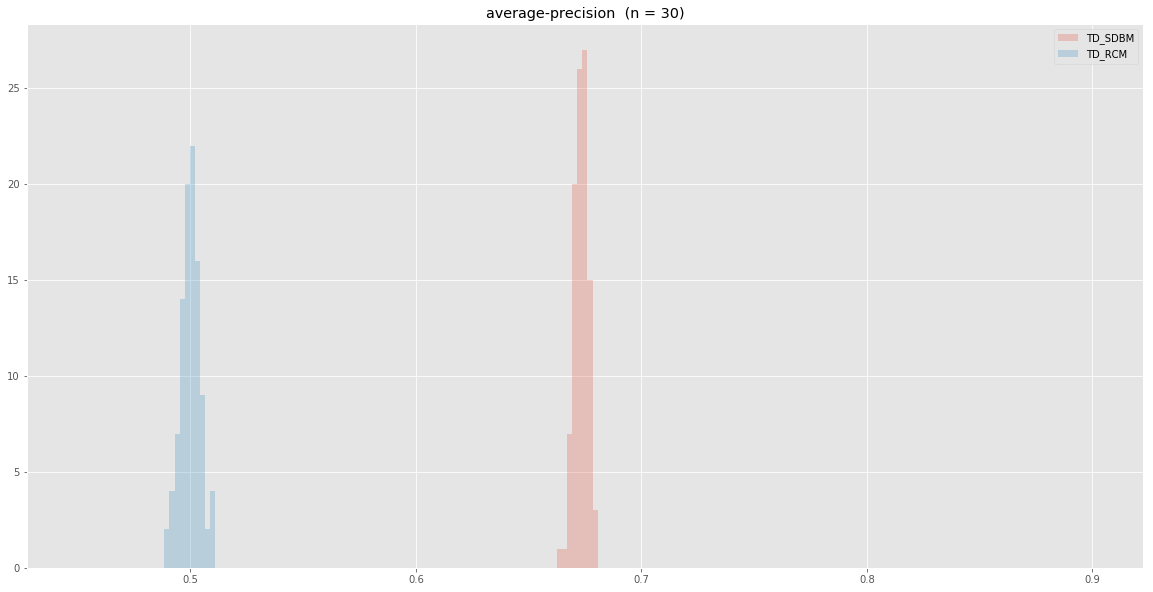

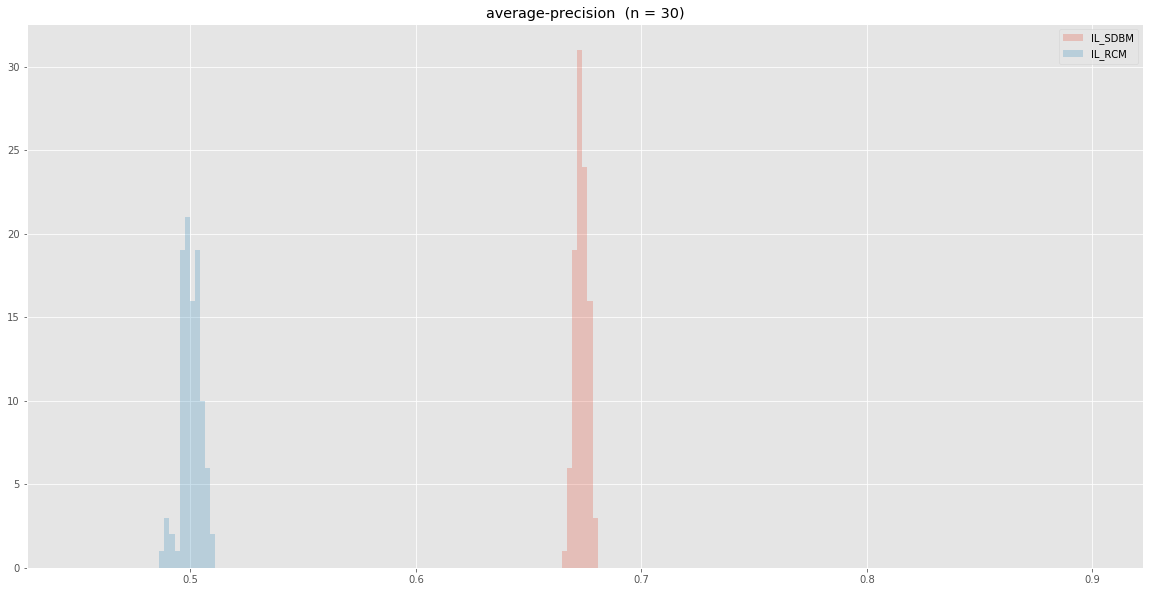

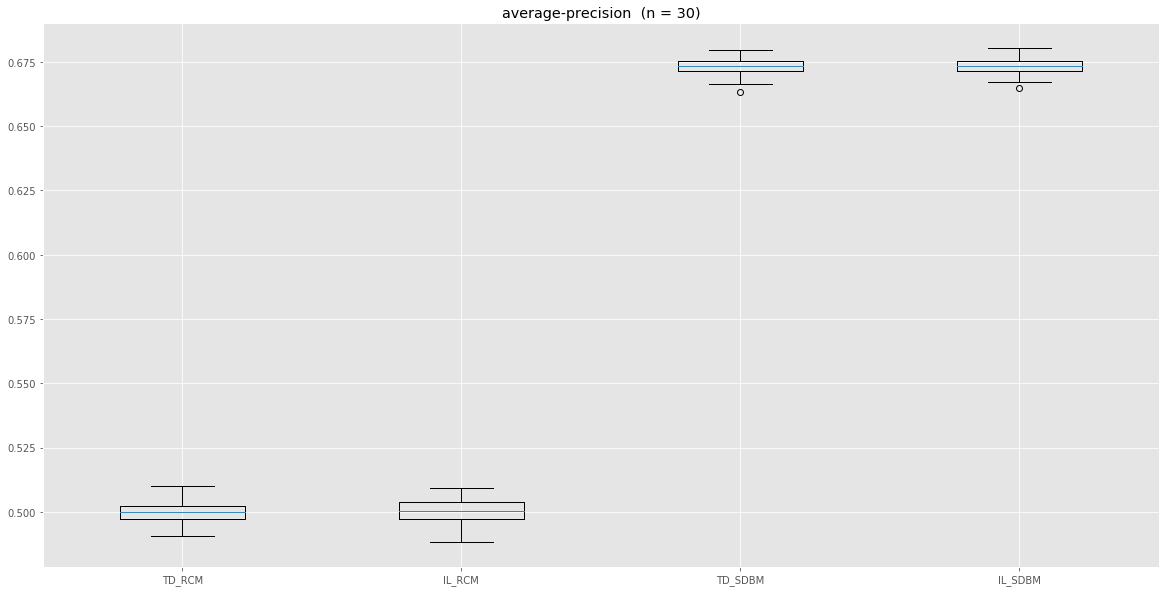

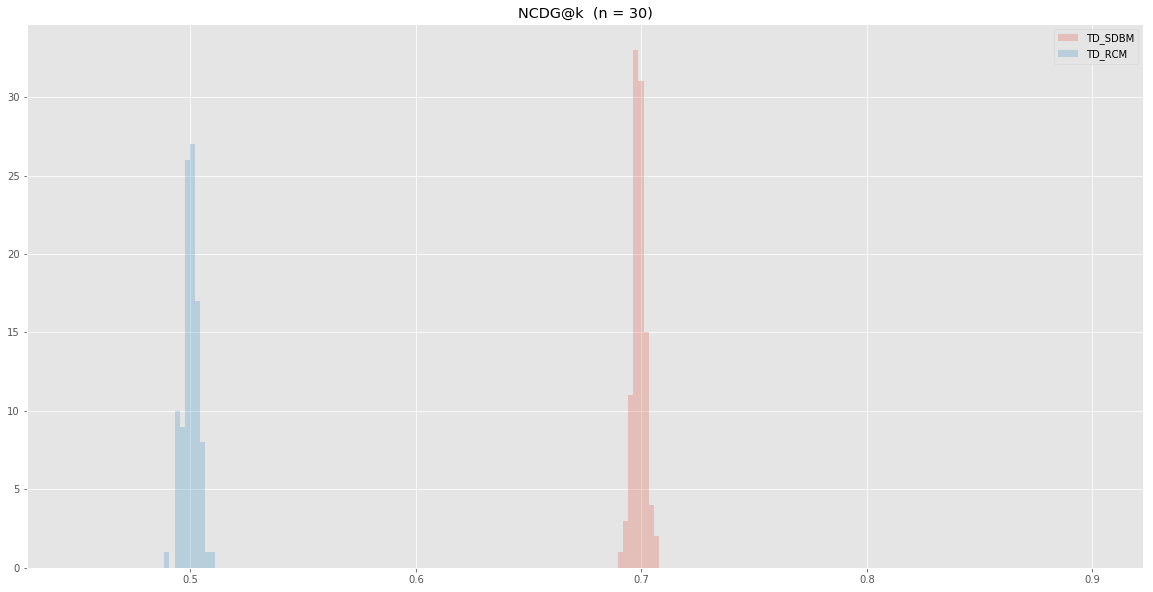

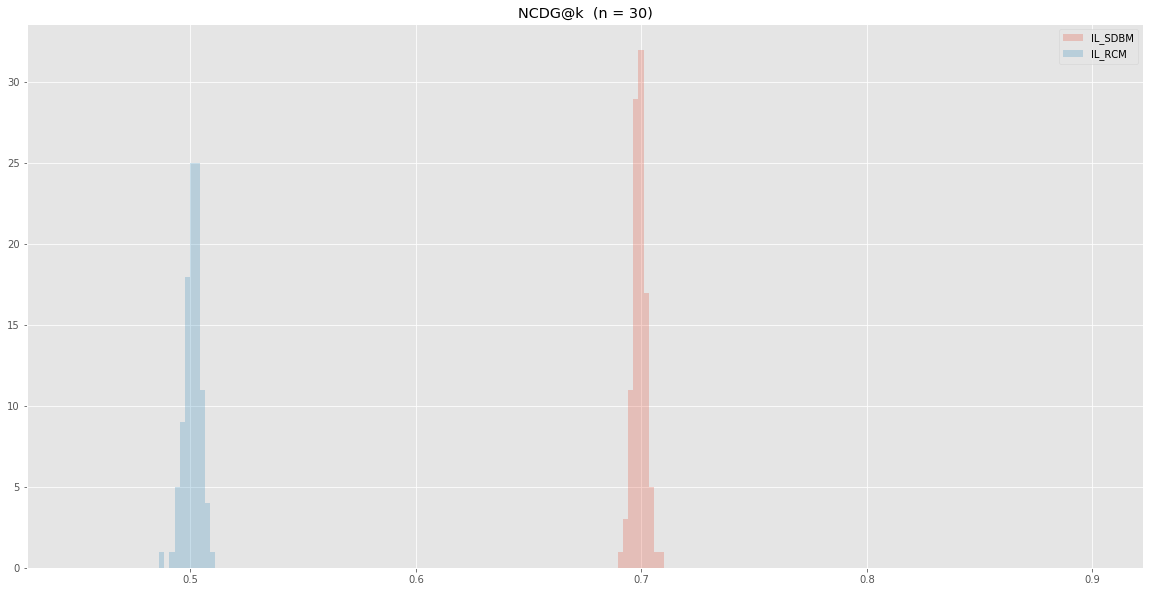

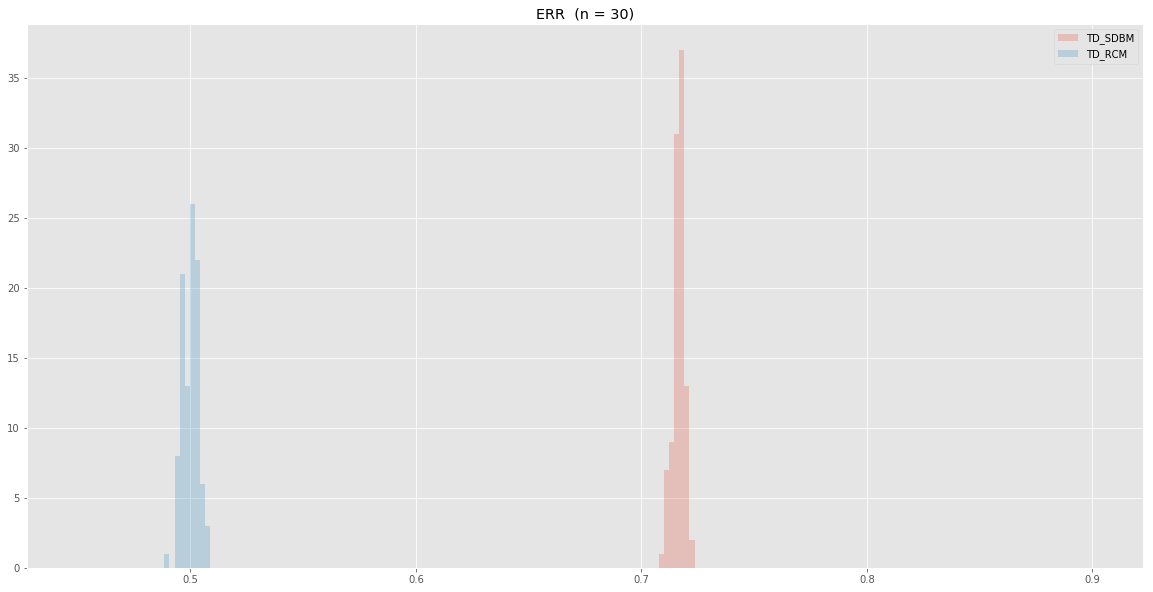

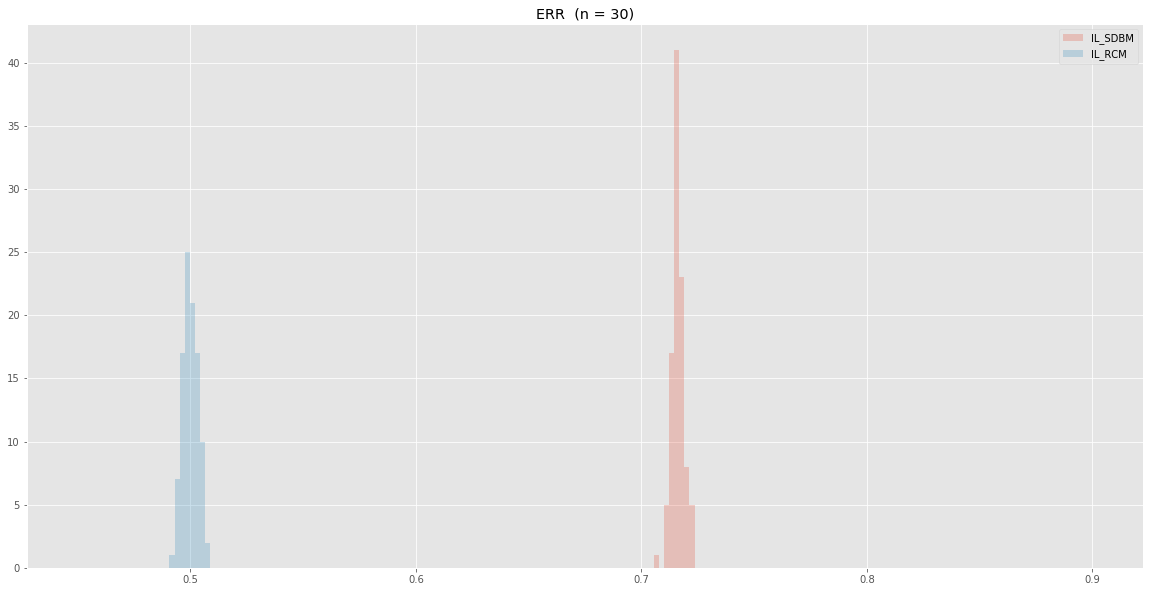

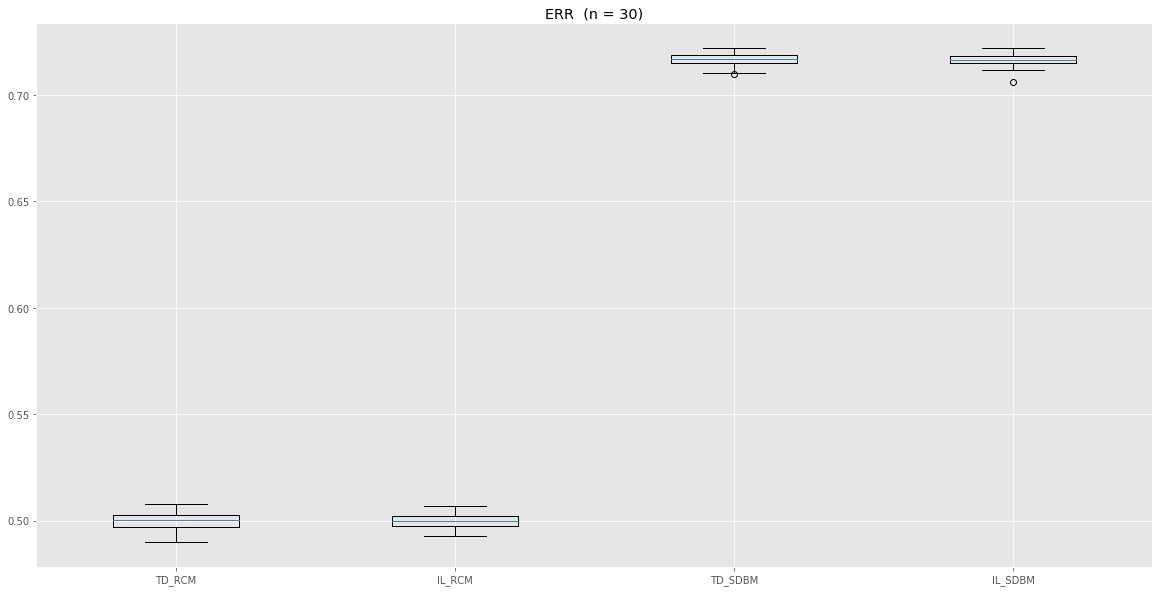

In [38]:
"""
Visualizations of the various groups
"""

print("Each group is generated by taking 30 proportions of wins (central limit theorem)\n")
for data in experiment_data:
    sim = simulation_results[data.metric]
    sim_teamdraft_RCM = sim["TeamDraftInterleaving"]["RandomClickModel"]
    sim_teamdraft_SDBM = sim["TeamDraftInterleaving"]["SimpleDynamicBayesianNetwork"]
    sim_interleaved_RCM = sim["BalancedInterleaving"]["RandomClickModel"]
    sim_interleaved_SDBM = sim["BalancedInterleaving"]["SimpleDynamicBayesianNetwork"]
        
    bins = np.linspace(0.45, 0.9, 200)
    #plt.hist(sim_interleaved_SDBM, bins, alpha=0.25, label='IL_SDBM')
    plt.hist(sim_teamdraft_SDBM, bins, alpha=0.25, label='TD_SDBM')
    #plt.hist(sim_interleaved_RCM, bins, alpha=0.25, label='IL_RCM')
    plt.hist(sim_teamdraft_RCM, bins, alpha=0.25, label='TD_RCM')
    
    title_text = data.metric + "  (n = 30)"
    plt.title(title_text)
    plt.legend(loc='upper right')
    plt.show()

    plt.hist(sim_interleaved_SDBM, bins, alpha=0.25, label='IL_SDBM')
    plt.hist(sim_interleaved_RCM, bins, alpha=0.25, label='IL_RCM')

    plt.title(title_text)
    plt.legend(loc='upper right')
    plt.show()
    
    plt.figure()
    plt.title(title_text)
    plt.boxplot([sim_teamdraft_RCM, sim_interleaved_RCM, sim_teamdraft_SDBM, sim_interleaved_SDBM])
    plt.xticks([1, 2, 3, 4], ['TD_RCM', 'IL_RCM', 'TD_SDBM', 'IL_SDBM',])
    plt.show()
   

## Step 7: Results and Analysis (30 points)

Compare the results of the offline experiments (i.e. the values of the 𝛥measure) with the results of the online experiment (i.e. proportion of wins), analyze them and reach your conclusions regarding their agreement.

Note:
We've implemented all metrics. For grading, please consider AveragePrecision (1 binary), NDCG@k and ERR (2 multi-graded)

In [39]:
TD_RCM_props = []
TD_SDBM_props = []

def find_average_proportions(wins_by_type):
   
    #the average proportions of win by E per pair given N simulations
    #gets the number of wins given a pair E-P and finds the average proportion in N experiments for this pair
    #average proportions of all pairs are calculated and returned
    
    no_experiments = len(wins_by_type)
    no_pairs = len(wins_by_type[0])
    avgs = np.zeros(no_pairs)
    denominator = np.empty(no_pairs)
    denominator.fill(no_experiments)
    
    for i in range(no_experiments):
        for j in range(no_pairs):
            res = wins_by_type[i][j]
            if(res == 1):
                avgs[j] += res #count the number of wins by E
            elif(res == 0):
                denominator[j] = denominator[j] - 1 #decrease the denominator when it's a tie
             
    return avgs/denominator

#for all the experiments and data metrics, calculates and storse the average proportions of win
for data in experiment_data:
    wins = win_results[data.metric]
    
    win_teamdraft_RCM = wins["TeamDraftInterleaving"]["RandomClickModel"]
    TD_RCM_props.append(find_average_proportions(win_teamdraft_RCM))
    
    win_teamdraft_SDBM = wins["TeamDraftInterleaving"]["SimpleDynamicBayesianNetwork"]
    TD_SDBM_props.append(find_average_proportions(win_teamdraft_SDBM))

In [40]:
print("Proportions of wins, team-draft, SDBM")
print(TD_SDBM_props[0]) #AP
print(TD_SDBM_props[1]) #NCDG
print(TD_SDBM_props[2]) #ERR
print("proportions of wins, team-draft,RCM")
print(TD_RCM_props[0]) #AP
print(TD_RCM_props[1]) #NCDG
print(TD_RCM_props[2]) #ERR

Proportions of wins, team-draft, SDBM
[ 0.54929577  0.76623377  0.71641791 ...,  0.3974359   0.52777778
  0.41428571]
[ 0.65384615  0.74074074  0.63768116 ...,  0.42465753  0.50704225
  0.54054054]
[ 0.67567568  0.72839506  0.63157895 ...,  0.52112676  0.54666667
  0.54929577]
proportions of wins, team-draft,RCM
[ 0.52727273  0.45901639  0.49230769 ...,  0.51851852  0.55555556
  0.50819672]
[ 0.48333333  0.61904762  0.46969697 ...,  0.38        0.50877193
  0.48214286]
[ 0.53333333  0.55384615  0.46       ...,  0.48611111  0.49090909  0.515625  ]


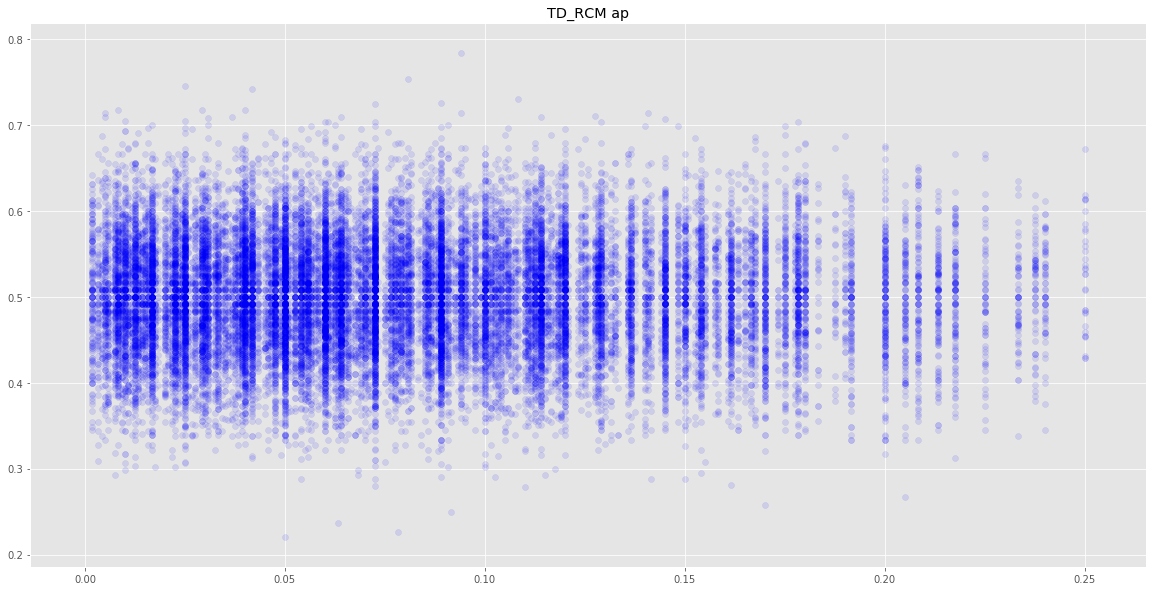

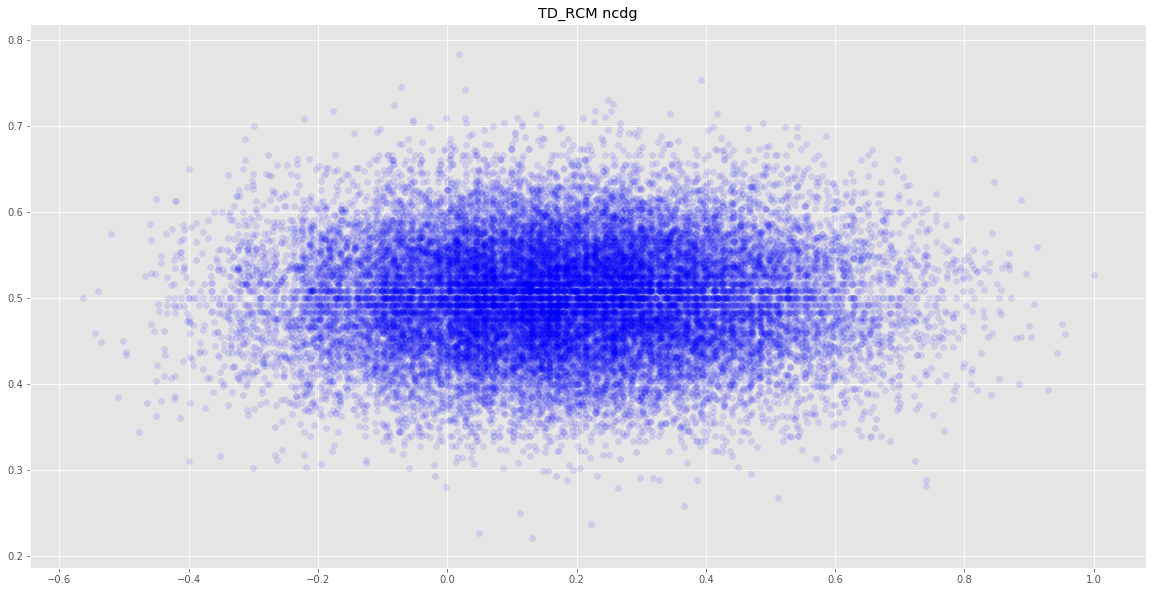

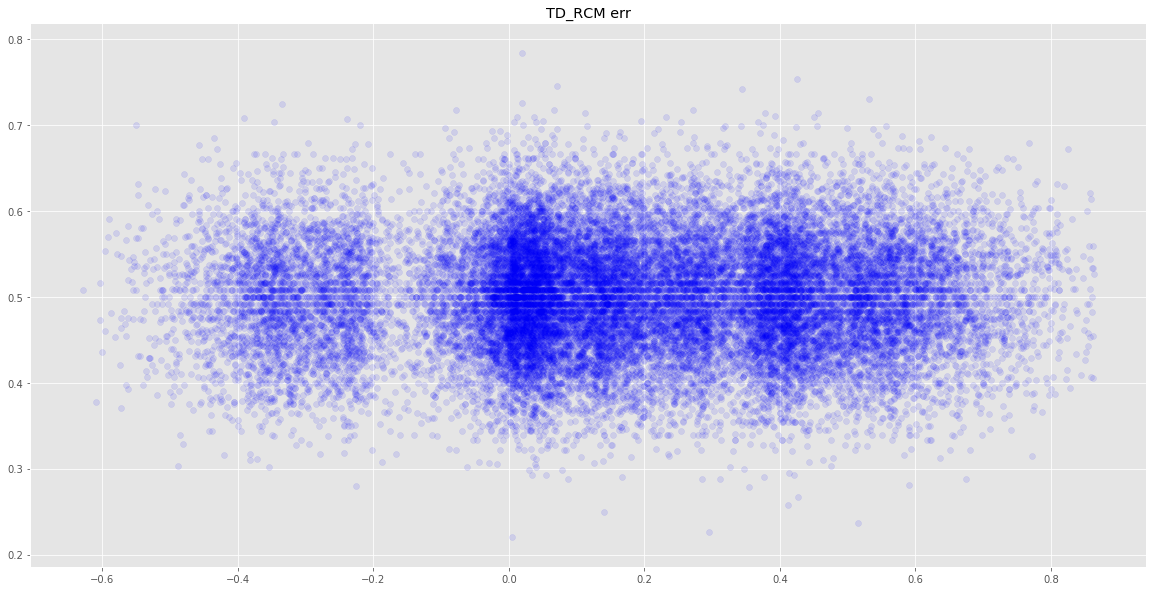

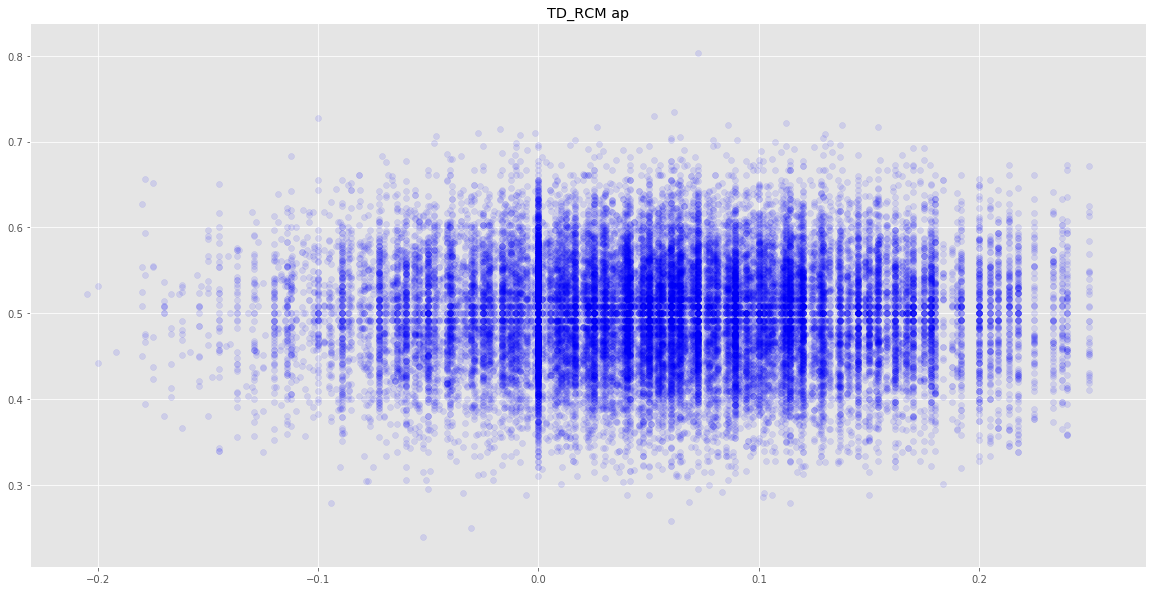

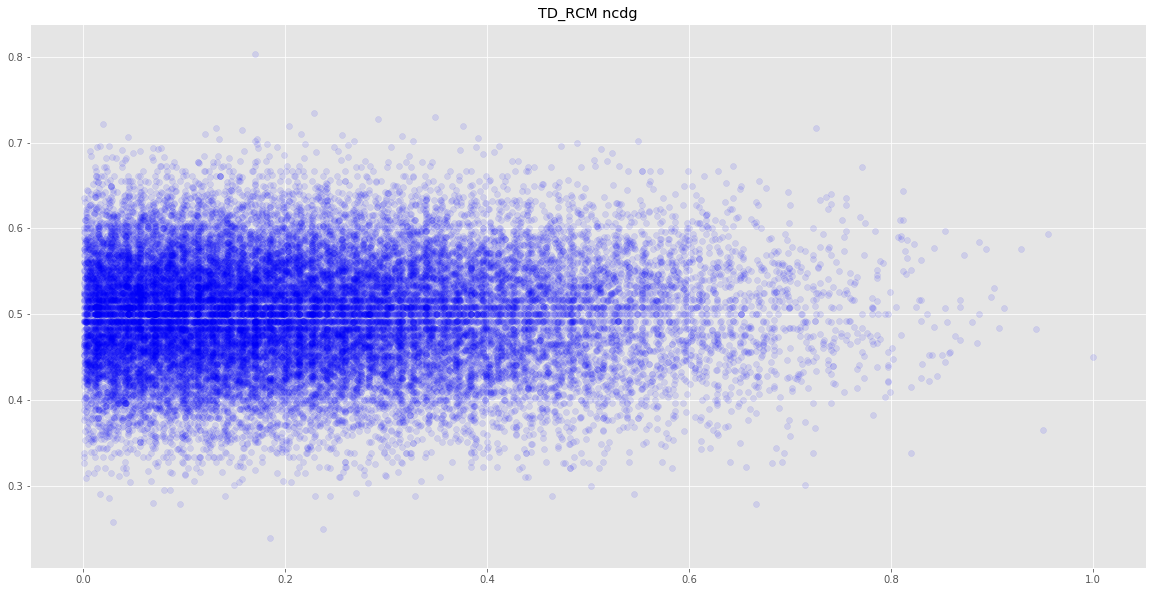

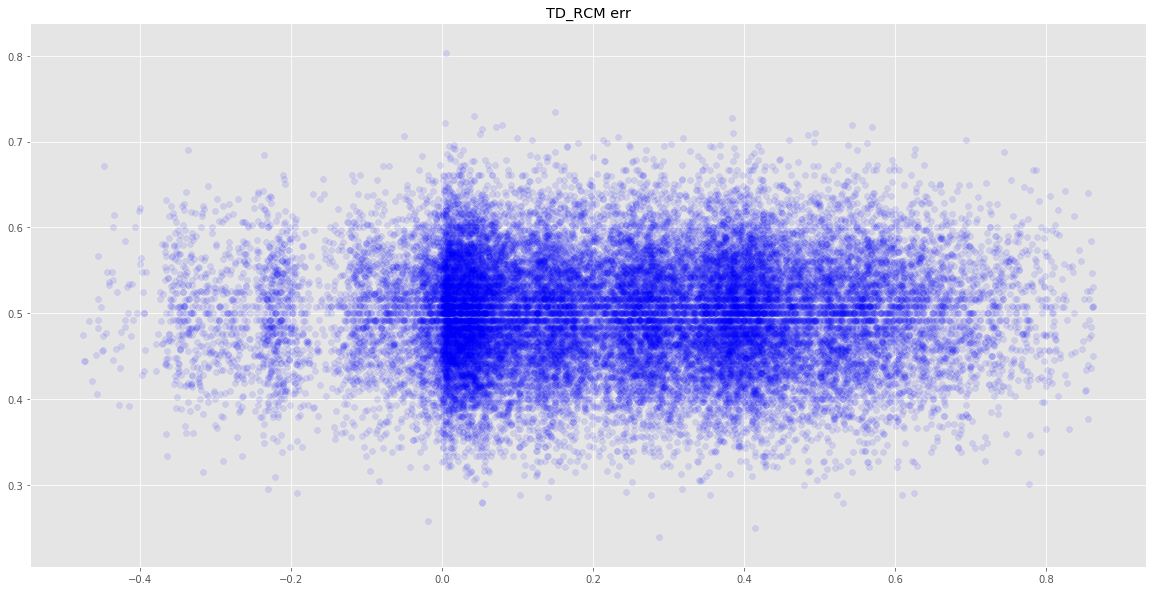

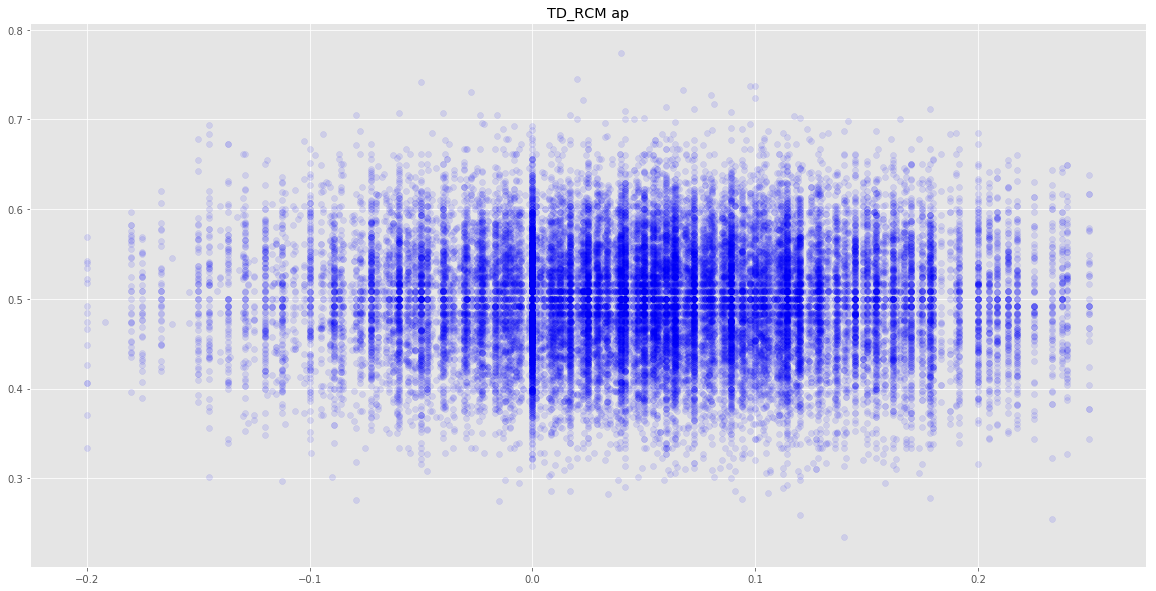

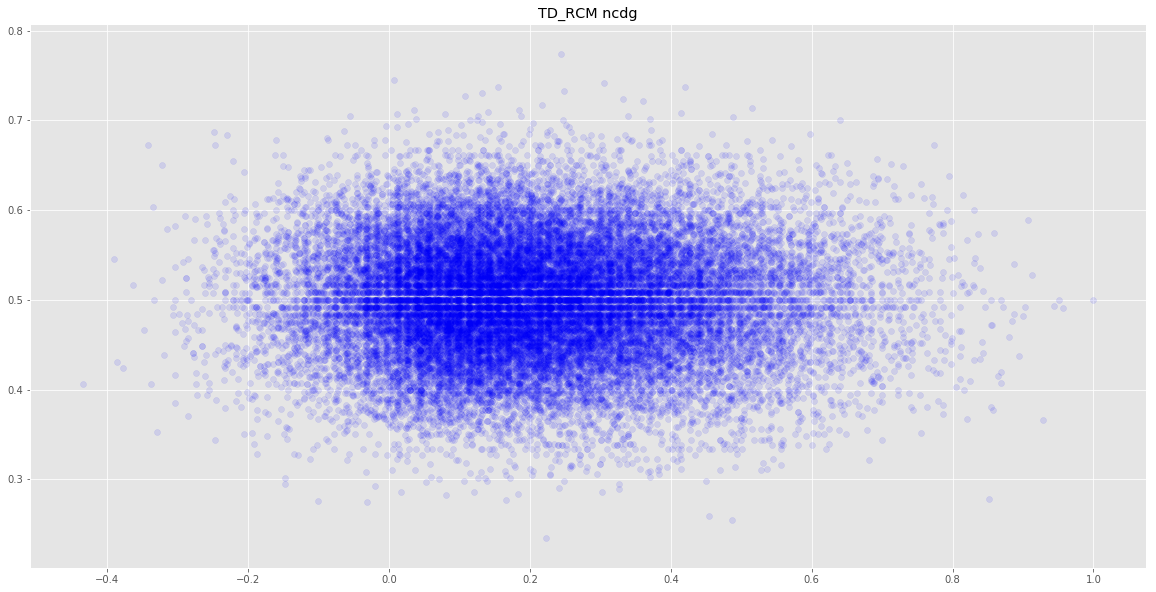

In [41]:
types = ['ap', 'ncdg', 'err'] #types of delta measure

#for each data metric, plots delta measure vs. proportions of win 
#PER PAIR, GIVEN AN INTERLEAVING METHOD AND A CLICK MODEL

for data in experiment_data:
    if(data.metric == "average-precision"):
        index = 0
    elif(data.metric == "NCDG@k"):
        index = 1
    elif(data.metric == "ERR"):
        index = 2

    dr = delta_results[data.metric]
    for ty in types:
        title = "TD_RCM " + ty 
        plt.title(title)
        plt.scatter(dr[0][ty],TD_RCM_props[index],c="blue", alpha=0.1)
        plt.show()
            

In [42]:
outputs = []
print("Results of the Pearson correlation tests")

#for each data metric performs Pearson correlation tests delta measure vs. proportions of win 
#PER PAIR, GIVEN AN INTERLEAVING METHOD AND A CLICK MODEL

for data in experiment_data:
    if(data.metric == "average-precision"):
        index = 0
    elif(data.metric == "NCDG@k"):
        index = 1
    elif(data.metric == "ERR"):
        index = 2
   
    dr = delta_results[data.metric]
    for ty in types:
        cf, p = stats.pearsonr(dr[0][ty],TD_RCM_props[index])
        output = data.metric + " Proportion of wins vs. " + ty + "\nTeam-draft interleaving \t RCM \t Coefficient = " + str(cf) + " p = " + str(p) + "\n"
        print(output)

Results of the Pearson correlation tests
average-precision Proportion of wins vs. ap
Team-draft interleaving 	 RCM 	 Coefficient = -0.000491966384291 p = 0.934447596411

average-precision Proportion of wins vs. ncdg
Team-draft interleaving 	 RCM 	 Coefficient = 0.00796976967876 p = 0.182708023018

average-precision Proportion of wins vs. err
Team-draft interleaving 	 RCM 	 Coefficient = 0.0105258250166 p = 0.0784366222196

NCDG@k Proportion of wins vs. ap
Team-draft interleaving 	 RCM 	 Coefficient = -0.00237796330694 p = 0.683602208355

NCDG@k Proportion of wins vs. ncdg
Team-draft interleaving 	 RCM 	 Coefficient = 0.0032432412335 p = 0.578312846689

NCDG@k Proportion of wins vs. err
Team-draft interleaving 	 RCM 	 Coefficient = 0.00988154690564 p = 0.0903394326466

ERR Proportion of wins vs. ap
Team-draft interleaving 	 RCM 	 Coefficient = -0.0110948873946 p = 0.0572560178103

ERR Proportion of wins vs. ncdg
Team-draft interleaving 	 RCM 	 Coefficient = -0.0101410318454 p = 0.082232

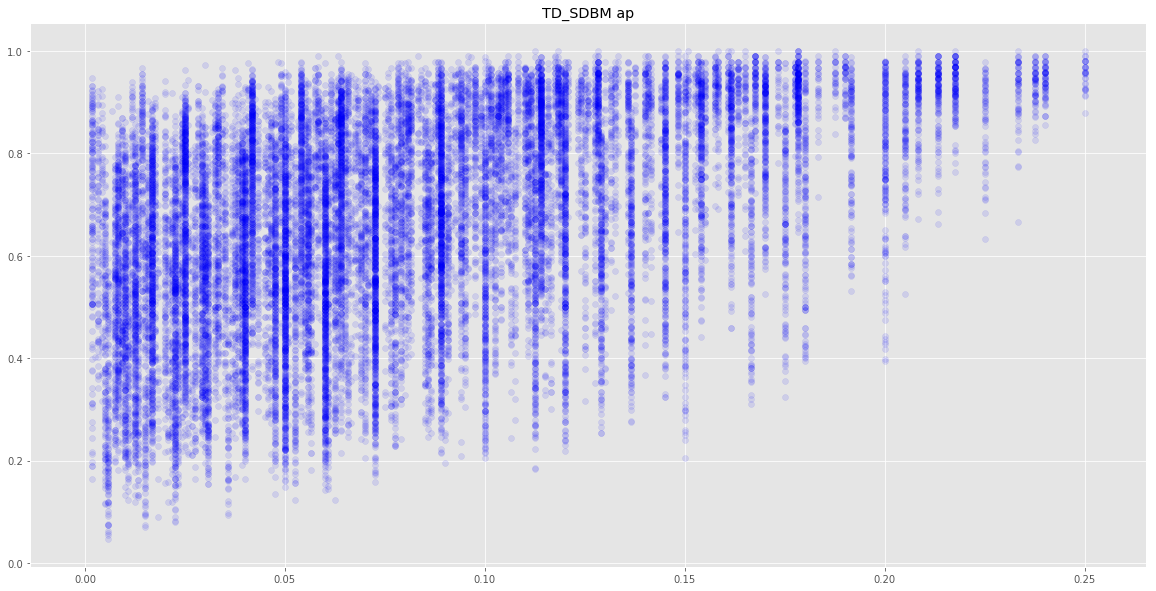

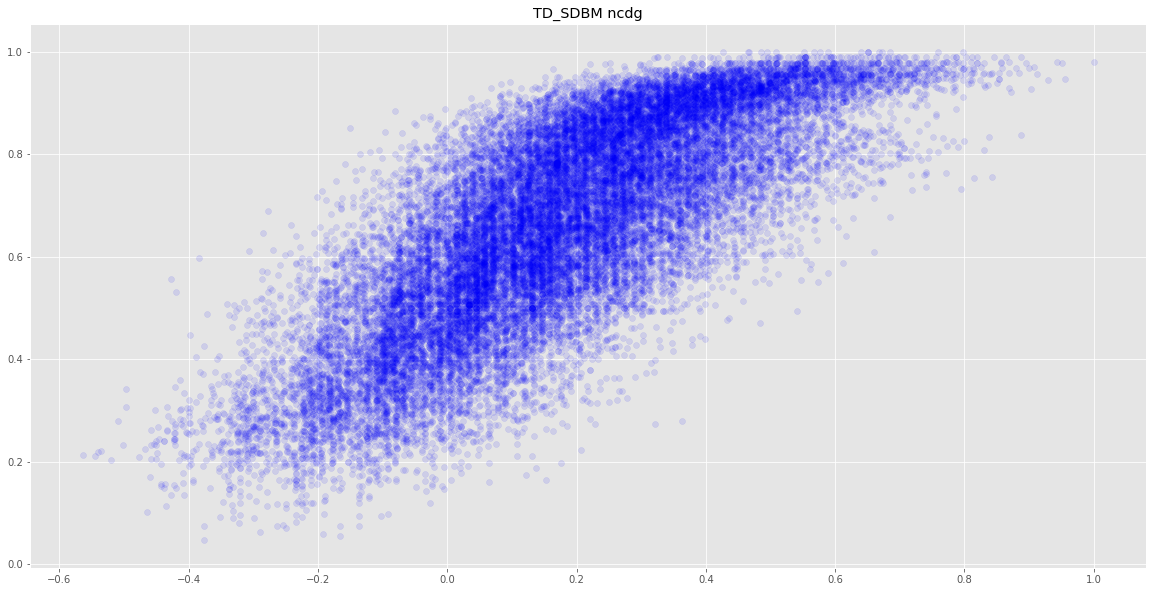

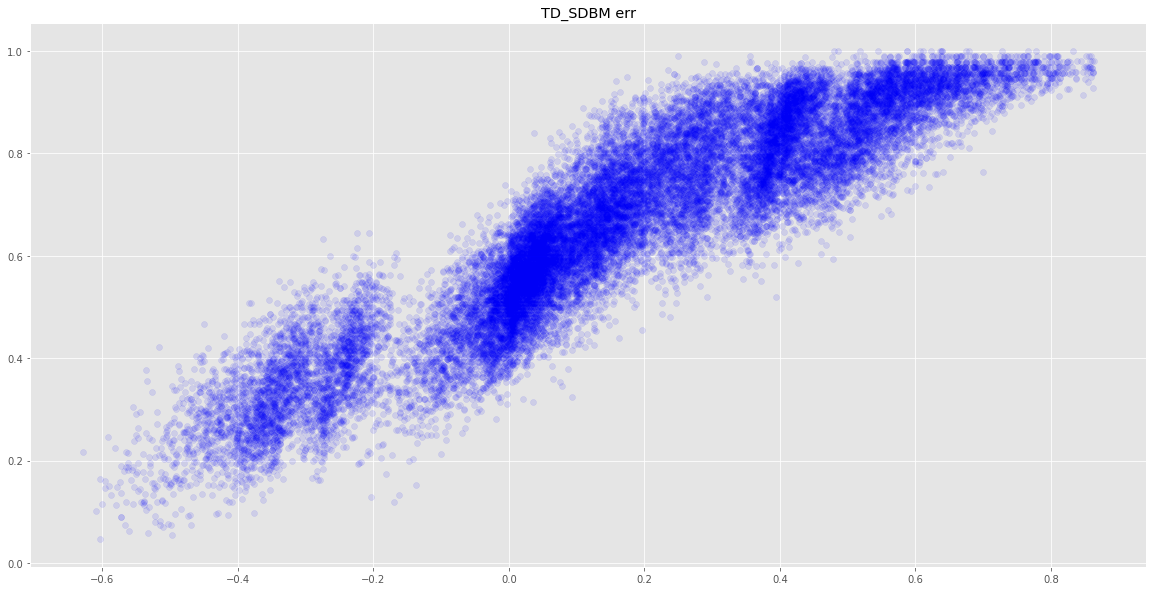

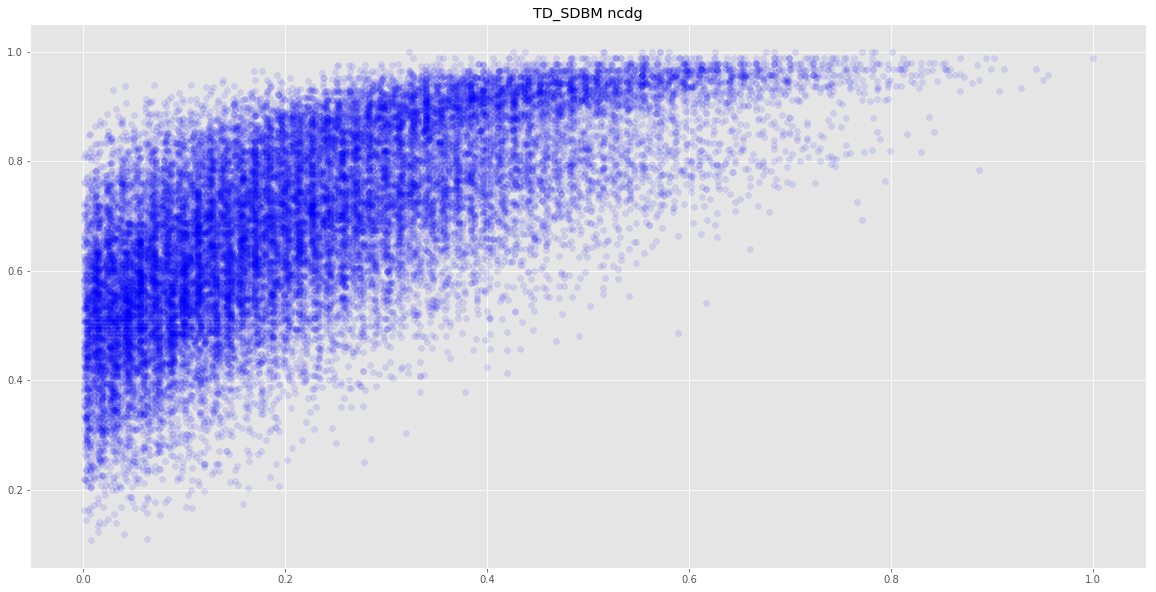

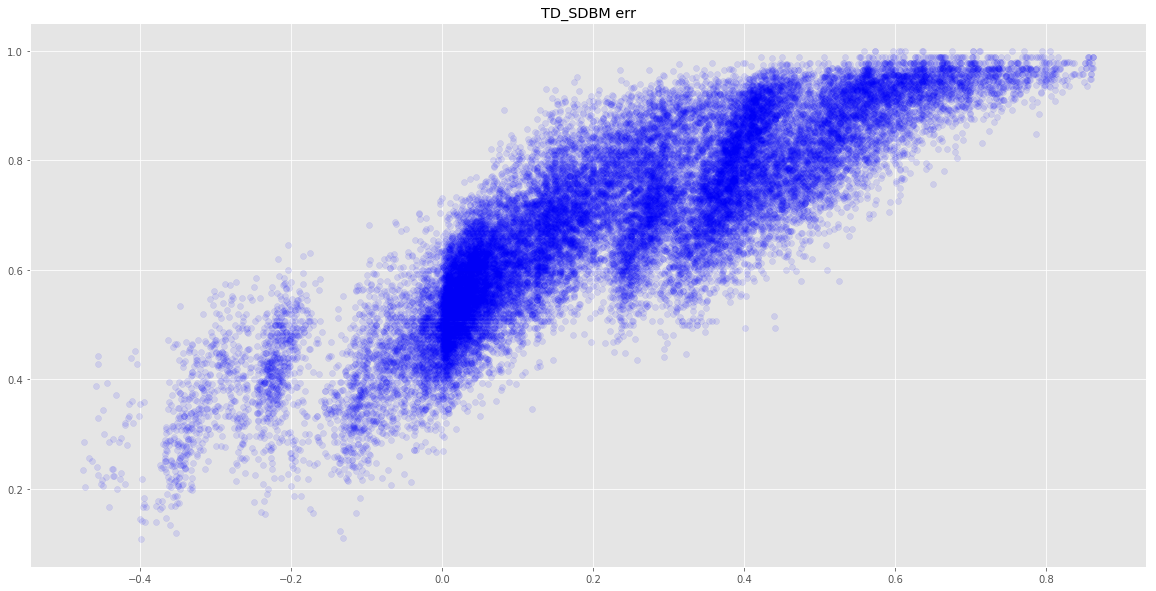

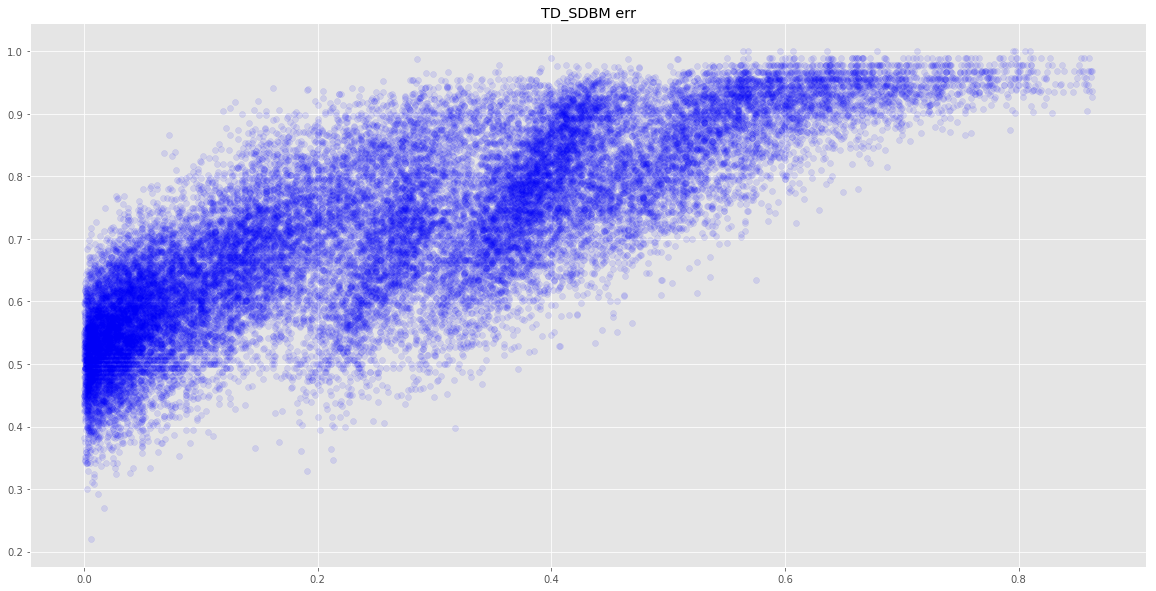

In [43]:
#for each data metric, plots delta measure vs. proportions of win 
#PER PAIR, GIVEN AN INTERLEAVING METHOD AND A CLICK MODEL

for data in experiment_data:
    if(data.metric == "average-precision"):
        index = 0
    elif(data.metric == "NCDG@k"):
        index = 1
    elif(data.metric == "ERR"):
        index = 2

    dr = delta_results[data.metric]
    for ty in types:
        title = "TD_SDBM " + ty 
        plt.title(title)
        plt.scatter(dr[0][ty],TD_SDBM_props[index],c="blue", alpha=0.1)
        plt.show()
            

In [44]:
#for each data metric performs Pearson correlation tests delta measure vs. proportions of win 
#PER PAIR, GIVEN AN INTERLEAVING METHOD AND A CLICK MODEL

for data in experiment_data:
    if(data.metric == "average-precision"):
        index = 0
    elif(data.metric == "NCDG@k"):
        index = 1
    elif(data.metric == "ERR"):
        index = 2
   
    dr = delta_results[data.metric]
    for ty in types:
        cf, p = stats.pearsonr(dr[0][ty],TD_SDBM_props[index])
        output = data.metric + " Proportion of wins vs. " + ty + "\nTeam-draft interleaving \t SDBM \t Coefficient = " + str(cf) + " p = " + str(p) + "\n"
        print(output)

average-precision Proportion of wins vs. ap
Team-draft interleaving 	 SDBM 	 Coefficient = 0.466279022852 p = 0.0

average-precision Proportion of wins vs. ncdg
Team-draft interleaving 	 SDBM 	 Coefficient = 0.778369943979 p = 0.0

average-precision Proportion of wins vs. err
Team-draft interleaving 	 SDBM 	 Coefficient = 0.916651955052 p = 0.0

NCDG@k Proportion of wins vs. ap
Team-draft interleaving 	 SDBM 	 Coefficient = 0.507823149132 p = 0.0

NCDG@k Proportion of wins vs. ncdg
Team-draft interleaving 	 SDBM 	 Coefficient = 0.666873382827 p = 0.0

NCDG@k Proportion of wins vs. err
Team-draft interleaving 	 SDBM 	 Coefficient = 0.863548117835 p = 0.0

ERR Proportion of wins vs. ap
Team-draft interleaving 	 SDBM 	 Coefficient = 0.551752388309 p = 0.0

ERR Proportion of wins vs. ncdg
Team-draft interleaving 	 SDBM 	 Coefficient = 0.669219350117 p = 0.0

ERR Proportion of wins vs. err
Team-draft interleaving 	 SDBM 	 Coefficient = 0.8092875461 p = 0.0



## Conclusions

In this homework, we utilized different interleaving methods, evaluation measures and click models. We have applied several tests to compare these methods, measures and models depending on the nature of the comparison that we would like to make and the nature of the data i.e. normally distributed or not.

We first conducted normality tests separately for the proportions of win for Team-Draft+Random Click Model, Balanced+Random Click Model, Team-Draft+Simple Dynamic Bayesian Network, Balanced+Simple Dynamic Bayesian Network. The overall results for these data after 30 simulations indicated normal distribution. Hence, as this does not violate the normality assumption of the t-test, we applied two-sample t-tests to compare the samples. 

When we compared Team-Draft+Random Click Model vs. Team-Draft+Simple Dynamic Bayesian Network, the p values was smaller than 0.05, which indicated that the null hypothesis was rejected. This means that there is a significant difference between the values we get from the first model and the second model and the mean of proportions of wins is higher in the SDBN model. It can be seen from the graphs and the boxplots that their standard deviations are rather small and they do not overlap for respective models.

This was exactly the same case for the Balanced+Random Click Model vs. Balanced+Simple Dynamic Bayesian Network comparision, where we got significant results, including better results for the SDBN model.

ANOVA was utilized to make multiple comparisons, comparing different click models utilizing different evaluation metrics. The results indicate that there were signficant distinctions between the outcomes obtained using different evaluation measures in SDBNs. 

Sign tests were employed to observe the difference between the win proportions of E and P. This was performed for different cases such that the difference in E and P when using Team-Draft+RCM, using Team-Draft+SDBN, using Balanced+RCM and using Balanced+SDBN.

Wilcoxon sign test results indicated that the difference between the quality of results from E and P were significant in all the cases where SDBN was utilized, whereas the differences were found to be non-significant in the case of RCMs, independent of the interleaving method we utilized. 

We created several correlation graphs between offline and online measures. In total there were 9 per click model. For every evaluation method we also checked the proportional score for the online method.

As part of the comparison between offline and online measures, we have plotted the delta measures for each pair in the simulation (delta measures for AP, NDCG, ERR for each E-P pair) versus the proportions of win for the related pair over 100 simulations.

It can be seen from the plots that for the RCM models these values do not seem the correlate with each other, whereas for the SDBN models we observe a linear-like correlation.

These observations were further investigated with Pearson correlation tests. We found that offline measures and online measures were highly correlated, each correlation coefficient being positive and closer to 1, for SDBN models, p value being very small and much less than 0.05. Intuitively, the random click model did not produce any significant correlation between offline and online measures. We can therefore say that the simulation nicely mirrors the inherent values measures by offline methods.

These results all point out to the idea that SDBN click model is better at predicting that E will be better than P, compared to RCM's random click behaviour, as the clicks follow a pattern depending on the relevance and they are not just clicks with overall chance probabilities (50%). In addition, offline delta measures and online evaluation metrics correspond positively to each other, particularly when SDBN is utilized, indicating that both evaluation methdos can be utilized in testing two search algorithms that produce ranked lists of documents given a query.
